### MODELO PARA PREDECIR LA DEFORESTACIÓN DEL AMAZONAS EN LOS PRÓXIMOS AÑOS

En este script se realiza la ingesta y preprocesamiento de los datos y se desarrolla el modelo.

Se prueban distintos parámetros del modelo para hallar la mejor configuración de la red neuronal a partir de varios arrays que contienen distintos valores para el número de :
- n_replics: réplicas de municipios falsos que se van a generar a partir de los verdaderos
- hidden_layers: capas intermedias de la red neuronal
- epochs: épocas con las que se va a entrenar el modelo
- batch_sizes: instancias por batch de aprendizaje

In [7]:
# TODO: repensar normalizacion de train (hay q hacerlo con todos los datos por año juntos, ej: todos los incrementos de deforestacion juntos) 
# GOAL: entrenar con ventanas del conjunto de train y luago testear con distintas ventanas del conjuntos de test

In [8]:
import numpy as np 
import pandas as pd 
import math, os
from sklearn import preprocessing
import gmplot
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, LSTM, Masking, Input, Dropout
from keras.layers.merge import concatenate
from keras.utils import plot_model
from keras.callbacks import ModelCheckpoint
pd.set_option('display.max_columns', None)

In [9]:
def create_paths():
    # Creates all the necessary folders. Check if data folder already created. If not, create it
    if not os.path.exists('modelos/'):
        os.makedirs('modelos/')
    if not os.path.exists('modelos2/img/'):
        os.makedirs('modelos2/img/')
    if not os.path.exists('mapas/'):
        os.makedirs('mapas/')
    if not os.path.exists('resultados/'):
        os.makedirs('resultados/')

In [10]:
def obtain_data():
    dfs={}
    for i in range(19):
        year=str(2000+i)
        file='../datos/DesmatamentoMunicipios' + year + '.csv'
        dfs[i] = pd.read_csv(file, encoding = "ISO-8859-1", index_col=0, sep=",")
        #eliminamos columnas irrelevantes
        dfs[i].drop(columns='Latgms', inplace=True)
        dfs[i].drop(columns='Longms', inplace=True)
        dfs[i].drop(columns='CodIbge', inplace=True)
        #df.rename(columns={0:'Latitud', 1:'Longitud', 2:'Municipio', 3:'Estado', 4: 'AreaKm2', 5:'Deforestacion', 6:'Incremento deforestacion', 7:'Bosque', 8:'Nubes', 9:'No observado', 10:'No bosque', 11:'Hidrografia', 12:'Check'} ,inplace=True)
        dfs[i].columns=['Latitud', 'Longitud', 'Municipio', 'Estado', 'Area total', 'Deforestacion ' + year, 'Incremento deforestacion ' + year, 'Bosque ' + year, 'Nubes ' + year, 'No observado ' + year, 'No bosque', 'Hidrografia', 'Check ' + year]
        dfs[i]=dfs[i][['Latitud', 'Longitud', 'Municipio', 'Estado', 'Area total', 'No bosque', 'Hidrografia', 'Deforestacion ' + year, 'Incremento deforestacion ' + year, 'Bosque ' + year, 'Nubes ' + year, 'No observado ' + year, 'Check ' + year]]
    return dfs

In [11]:
def update_2019(df):
    file='../datos/terrabrasilis_amazon.csv'
    df_new = pd.read_csv(file, encoding = "UTF-8", sep=",")
    #limpiamos el dataset
    df_new.drop(['geocode_ibge'], axis=1, inplace=True)
    df_new = df_new.groupby(['municipality', 'state', 'year'])['areakm'].agg('sum').reset_index()
    
    estados = {
    'MATO GROSSO': 'MT', 
    'MARANHÃO': 'MA',
    'AMAPÁ': 'AP',
    'RORAIMA': 'RR',
    'AMAZONAS': 'AM',
    'PARÁ': 'PA',
    'RONDÔNIA': 'RO',
    'TOCANTINS': 'TO',
    "ACRE": "AC"
    }
    
    # Mismo formato de nombre de municipio
    for index, row in df_new.iterrows():
        df_new.iloc[index,1] = estados[row['state']]
        df_new.iloc[index,0] = row['municipality'] + " (" + str(df_new.iloc[index,1]) + ")"
        df_new
    
    # 3 casos particulares en los que el nombre tiene pequeñas diferencias entre ambos datasets
    df_new.loc[df_new['municipality']=='SANTA IZABEL DO PARÁ (PA)', 'municipality'] = 'SANTA ISABEL DO PARÁ (PA)'
    df_new.loc[df_new['municipality']=='ELDORADO DO CARAJÁS (PA)', 'municipality'] = 'ELDORADO DOS CARAJÁS (PA)'
    df_new.loc[df_new['municipality']=='POXORÉU (MT)', 'municipality'] = 'POXORÉO (MT)'
        
    # Upper del municipio para que tengan el mismo formato
    for index, row in df.iterrows():
        df.iloc[index,0] = df.iloc[index,0].upper()
        
    # Actualizamos los datos antiguos con los nuevos
    for index, row in df_new.iterrows():
        inc = 'Incremento deforestacion ' + str(row['year'])
        if row['year']==2019:
            df.loc[df['Municipio']==row['municipality'], 'Deforestacion 2019'] = df.loc[df['Municipio']==row['municipality'], 'Deforestacion 2018'] + row['areakm']
            df.loc[df['Municipio']==row['municipality'], inc] = row['areakm']
            df.loc[df['Municipio']==row['municipality'], 'Bosque 2019'] = df.loc[df['Municipio']==row['municipality'], 'Bosque 2018'] - row['areakm']
            df.loc[df['Municipio']==row['municipality'], 'Nubes 2019'] = 0
            df.loc[df['Municipio']==row['municipality'], 'No observado 2019'] = 0
            df.loc[df['Municipio']==row['municipality'], 'Check 2019'] = 100
        else:
            df.loc[df['Municipio']==row['municipality'], inc] = row['areakm']
            
    total=0
    # Si no hay dato de un municipio en 2019, asumimos que no ha habido deforestacion
    for index, row in df.iterrows():
        if math.isnan(row[-1]):
            #total+=1
            df.loc[df['Municipio']==row['Municipio'], 'Deforestacion 2019'] = row['Deforestacion 2018']
            df.loc[df['Municipio']==row['Municipio'], 'Incremento deforestacion 2019'] = 0
            df.loc[df['Municipio']==row['Municipio'], 'Bosque 2019'] = row['Bosque 2018']
            df.loc[df['Municipio']==row['Municipio'], 'Nubes 2019'] =  row['Nubes 2018']
            df.loc[df['Municipio']==row['Municipio'], 'No observado 2019'] = row['No observado 2018']
            df.loc[df['Municipio']==row['Municipio'], 'Check 2019'] = 100
    
    #print("--------- Municipios sin variaciones en 2019 (sus incrementos del año anterior son <5km^2, así que tiene sentido):", total)
    
    return df

In [12]:
def create_df(dfs):
    df=dfs[0]
    dic={}
    for idx, row in df.iterrows():
            if row['Municipio'] in dic:
                dic[row['Municipio']]+=1
            else:
                dic[row['Municipio']]=1

    repetidos=[]
    for key, value in dic.items():
        if value==2:
            repetidos.append(key)

    rep= df.Municipio.isin(repetidos)
    mismo_municipio =  df[rep]
    #print("Hay algunos municipios con el mismo nombre en 2 estados distintos:")
    #print(mismo_municipio.loc[:,'Latitud':'Area total'])

    df=dfs[0]
    for idx, value in dfs.items():
        value['Municipio']=value['Municipio'] + " (" + value['Estado'] + ")"
        if idx > 0:
            value.drop(columns='Latitud', inplace=True)
            value.drop(columns='Longitud', inplace=True)
            value.drop(columns='Estado', inplace=True)
            value.drop(columns='Area total', inplace=True)
            value.drop(columns='Hidrografia', inplace=True)
            value.drop(columns='No bosque', inplace=True)
            df=pd.merge(df, value, on='Municipio')

    # reorder columns
    cols = df.columns.tolist()
    cols = cols[2:4] + cols[0:2] + cols[4:]
    df = df[cols]
    
    df = update_2019(df)
    return df

In [13]:
def shuffle_df(df):
    # El dataset viene ordenado por deforestacion, de mayor a menor. Para entrenar el modelo alteramos el orden de forma aleatoria."
    df = df.sample(frac=1)
    df.reset_index(inplace=True, drop=True)
    df.head()
    return df

In [14]:
def plot_map(df, name):
    print("Dibujamos el mapa de " + str(len(df['Latitud'])) + " municipios")
    gmap = gmplot.GoogleMapPlotter(df['Latitud'].values[0], df['Longitud'].values[0], 5) # coordenadas del primer municipio del dataframe
    gmap.heatmap(df['Latitud'], df['Longitud']) 
    gmap.draw(name)
    print("Mapa de calor generado")

In [15]:
def generate_fake_data(df, n_replic):
    if n_replic < 1:
        return
    fake_data=[]
    std=df.std()
    #print(std)
    for idx, row in df.iterrows():
        for i in range(n_replic):
            munic = row['Municipio']+' fake_'+str(i)
            estado = row['Estado']
            lat = row['Latitud']+std['Latitud']*0.1*np.random.uniform(-1,1) # variacion del 10% de la desviación típica
            long = row['Longitud']+std['Longitud']*0.1*np.random.uniform(-1,1) # variacion del 10% de la desviación típica
            area = row['Area total']+row['Area total']*0.5*np.random.uniform(-1,1) # variacion del 50% del valor real
            no_bosq = row['No bosque']+row['No bosque']*0.5*np.random.uniform(-1,1) # variacion del 10% del valor real
            hidro = row['Hidrografia']+row['Hidrografia']*0.5*np.random.uniform(-1,1) # variacion del 10% del valor real
            temp = []
            for j in range(20):    #TODO: Normalizar por año y append todas a la vez, no se puede cambiar el area cada año
                #year = 2000 + j
                if len(temp) > 5:
                    incr = row[n_vars_temp*j+8]   # 7 vars fijas + 1 defor para llegar al incremento
                    proporcion = incr/row['Area total']
                    t = area*proporcion
                    incr = t+t*0.05*np.random.uniform(-1,1)
                    defor = temp[-6] + incr
                    bosque = temp[-4] - incr
                    temp.extend([defor,incr, bosque])
                else:
                    proporcion = row[j+7]/row['Area total']
                    t = area*proporcion
                    defor = t+t*0.05*np.random.uniform(0,1)
                    bosque = area - (defor + no_bosq + hidro)
                    temp.extend([defor,float('NaN'), bosque])
                nubes = 0
                no_obs = 0
                suma = defor + no_bosq + hidro + bosque + nubes + no_obs
                check = suma/area*100
                temp.extend([nubes, no_obs, check])
            fixed = [munic, estado, lat, long, area, no_bosq, hidro]     
            fake_row = np.concatenate((fixed, temp))
            fake_data.append(fake_row)
    fake_df = pd.DataFrame(fake_data, columns=df.columns)
    fake_df = fake_df.infer_objects()
    return fake_df

In [16]:
def series_to_supervised(temporal_vars, year_ini_train=0, window_size=3, n_vars_temp=6):
    # ensure all data is float
    temporal_vars = temporal_vars.astype('float32')
    temporal_train = temporal_vars.iloc[:, n_vars_temp*year_ini_train:-window_size*n_vars_temp]
    temporal_test = temporal_vars.iloc[:, -window_size*n_vars_temp:]
    return temporal_train, temporal_test

In [66]:
def preprocess_train(temporal_train, fixed_vars, n_vars_temp, window_size):
    # normalize features
    y = temporal_train.iloc[:,-5].values.reshape(-1, 1) # reshape in 2D, we get 'Incremento deforestacion' as y
    scaler2 = MinMaxScaler(feature_range=(0, 1))  # guardamos el scaler de incrementos de deforestacion  del último año para normalizar los test (hipotetizamos los valores erán los más similares a los años venideros)
    y = scaler2.fit_transform(y)
    
    scaler = MinMaxScaler(feature_range=(0, 1))
    temporal_train = scaler.fit_transform(temporal_train)
    # get rid of nan values: set them to -1 so the model ommits this values in the masking layer
    temporal_train = pd.DataFrame(temporal_train)
    temporal_train = temporal_train.fillna(-1)
    
    i=0
    x=[]
    # data structure for LSTM: append all the windows of size=window_size
    while (i+window_size)*n_vars_temp <= temporal_train.shape[1]:
        if i==0:
            y=temporal_train.iloc[:,(i+window_size)*n_vars_temp-5].values.reshape(-1, 1)
        else:
            y=np.concatenate((y, temporal_train.iloc[:,(i+window_size)*n_vars_temp-5].values.reshape(-1, 1)), axis=0) # reshape in 2D, we get 'deforestacion' as y
        a=temporal_train.iloc[:,i*n_vars_temp:(i+window_size-1)*n_vars_temp].values
        for elem in a:
            elems_lstm=[]
            for j in range(int(len(elem)/n_vars_temp)):
                elems_lstm.append(elem[j*n_vars_temp:(j+1)*n_vars_temp])
            x.append(elems_lstm)
        i+=1
    X1=np.array(x)

    # data structure for Dense
    # One hot encoding 
    fixed_vars = pd.concat([fixed_vars,pd.get_dummies(fixed_vars['Estado'])],axis=1)
    # Drop column as it is now encoded
    fixed_vars = fixed_vars.drop('Estado',axis = 1)
    scaler3 = MinMaxScaler(feature_range=(0, 1))
    x = scaler3.fit_transform(fixed_vars.iloc[:,1:]) # nombre del municipio en la primera columna
    x = np.array(x)
    # append the fixed informations as many times as windows we have
    X2 = x
    for j in range(i-1):
        X2 = np.concatenate((X2, x), axis=0)
    
    
    return X1, X2, y, scaler, scaler2, scaler3

In [58]:
def create_model(window_size, n_vars_temp, hidden_layers, mask=1):
    # LSTM para variables temporales
    input_temporal = Input(shape=(window_size-1, n_vars_temp))
    if mask==0:
        lstm = LSTM(5, activation='relu')(input_temporal) #, unroll =True) -> check what it is
    else:
        masking = Masking(mask_value=-1)(input_temporal)
        lstm = LSTM(5, activation='relu', dropout=0.3)(masking)
    dense_1 = Dense(16, activation = 'relu')(lstm)
    
    # Dense para variables fijas
    input_fijo = Input(shape=(X2_train.shape[1],))
    dense_2 = Dense(32, activation = 'relu')(input_fijo)
    
    # concateno las 2 redes
    merge = concatenate([dense_1, dense_2])
    dense = [merge]
    for i in range(hidden_layers):
        dense.append(Dense(16, activation = 'relu')(dense[-1]))
    dropout = Dropout(0.2)(dense[-1])
    output = Dense(1, activation = 'relu')(dropout)
    model = Model(inputs=[input_temporal, input_fijo], outputs=output)
    
    # summarize layers
    print(model.summary())
    # plot graph
    #plot_model(model, to_file='modelos2/img/model_'+str(hidden_layers)+'.png')
    return model

In [89]:
def preprocess_test(temporal_test, X2_train, n_vars_temp, scaler, scaler2, scaler3):
    # data structure for LSTM
    x = temporal_test.values[:,0:-n_vars_temp]
    y = temporal_test.values[:,-5].reshape(-1, 1) # reshape in 2D
    # normalize features and get rid of nan values: set them to -1 so the model ommits this values in the masking layer
    x = scaler.fit_transform(x)
    x = pd.DataFrame(x)
    x = x.fillna(-1)
    x = x.values
    y = scaler2.fit_transform(y)
    y = pd.DataFrame(y)
    y = y.fillna(-1)
    y = y.values
    
    # structure in arrays to be the input of the LSTM
    vars_lstm=[]
    for mun in x:
        municipio=[]
        j=0
        while (j+1)*n_vars_temp <= x.shape[1]: # last year is for y
            municipio.append(mun[j*n_vars_temp:(j+1)*n_vars_temp])
            j+=1
        vars_lstm.append(municipio)

    vars_lstm=np.array(vars_lstm)
    X1 = vars_lstm
    X2 = X2_train[:len(X1)]
    return X1, X2, y

In [60]:
def evaluate_test(municipios, y, y_pred):
    # rescaling
    y=scaler2.inverse_transform(y).flatten()
    y_pred=scaler2.inverse_transform(y_pred).flatten()
    errores = []
    num_test = len(y_pred)
    for i in range(num_test):
        delta = y[i] - y_pred[i] # calculate the absolute error
        error = abs(delta)
        errores.append(error)
    test = {'Municipio': municipios.values.flatten(), 'Expected': y, 'Predicted': y_pred, 'Error': errores}
    test = pd.DataFrame(test)
    print(test)
    total = test.sum()
    print("Muestra:", num_test, "municipios")
    print('Error absoluto medio:', np.array(errores).mean())
    print('Deforestación predicha:', total['Predicted'], "\nDeforestación real:", total['Expected'], "\nError (%):", abs(total['Predicted']-total['Expected'])/total['Expected']*100)
    
    return test, total

In [21]:
create_paths()

dfs = obtain_data()
df = create_df(dfs)
df.to_csv('../datos/datos_reales.csv')

print("\nEl area total cubierta por los municipios es: " + str(df.sum(axis = 0, skipna = True)[4]) + " km^2, mientras el area total de la Amazonia es de 5,5M km^2.")
print("Por ello, podemos afirmar que estamos cubriendo una superficie que supone el 92% del total.\n")

plot_map(df, 'mapas/mapa.html')

n_vars_temp = df.loc[:,'Deforestacion 2000':].shape[1]//20 # number of variables per year

#shuffle data
df = shuffle_df(df)


El area total cubierta por los municipios es: 5068048 km^2, mientras el area total de la Amazonia es de 5,5M km^2.
Por ello, podemos afirmar que estamos cubriendo una superficie que supone el 92% del total.

Dibujamos el mapa de 760 municipios
Mapa de calor generado


Datos obtenidos
Dibujamos el mapa de 760 municipios
Mapa de calor generado


/home/luisjvca/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:355: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/home/luisjvca/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:356: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)


Train: (6840, 3, 6) (6840, 14) (6840, 1)
Validation: (760, 3, 6) (760, 14) (760, 1)
Creando el modelo...
	Capas intermedias 1
	Número de épocas: 5
	Batch size: 32
	Muestra para training: 760 municipios
Model: "model_54"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_107 (InputLayer)          (None, 3, 6)         0                                            
__________________________________________________________________________________________________
masking_54 (Masking)            (None, 3, 6)         0           input_107[0][0]                  
__________________________________________________________________________________________________
lstm_54 (LSTM)                  (None, 5)            240         masking_54[0][0]                 
_______________________________________________________________________________________

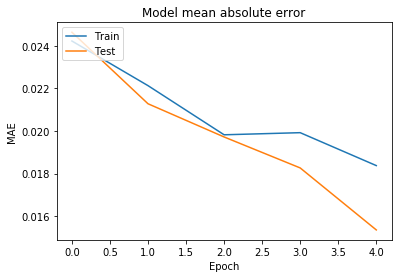

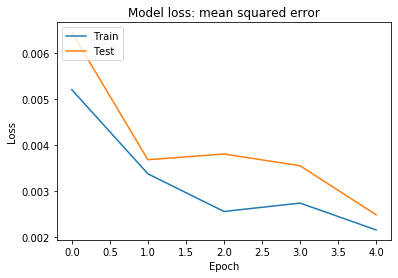

                      Municipio    Expected  Predicted      Error
0                   FÁTIMA (TO)    0.000000   0.000000   0.000000
1      SANTA CRUZ DO ARARI (PA)    0.000000   0.171347   0.171347
2             SERINGUEIRAS (RO)    6.869486   4.368770   2.500716
3                   PORTEL (PA)  107.897858  23.925865  83.971992
4    ALTA FLORESTA D'OESTE (RO)    5.045241   5.865407   0.820165
..                          ...         ...        ...        ...
755            SANTA LUZIA (MA)    1.311436   0.000000   1.311436
756               ALVORADA (TO)    0.000000   0.000000   0.000000
757       PONTES E LACERDA (MT)    2.124425   3.105428   0.981003
758       VITÓRIA DO XINGU (PA)   47.117195   7.779820  39.337376
759  SÃO FÉLIX DO ARAGUAIA (MT)   20.558084   9.015614  11.542471

[760 rows x 4 columns]
Muestra: 760 municipios
Error absoluto medio: 4.728323
Deforestación predicha: 3562.8937674351037 
Deforestación real: 6050.168898411095 
Error (%): 41.110837940891265
Creando el model

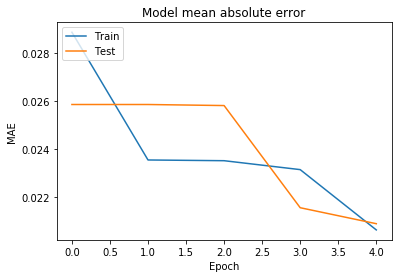

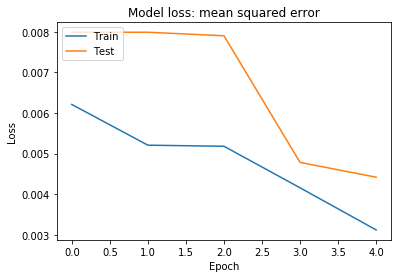

                      Municipio    Expected  Predicted      Error
0                   FÁTIMA (TO)    0.000000   0.000000   0.000000
1      SANTA CRUZ DO ARARI (PA)    0.000000   8.353405   8.353405
2             SERINGUEIRAS (RO)    6.869486   0.000000   6.869486
3                   PORTEL (PA)  107.897858  19.985826  87.912033
4    ALTA FLORESTA D'OESTE (RO)    5.045241   0.000000   5.045241
..                          ...         ...        ...        ...
755            SANTA LUZIA (MA)    1.311436   0.000000   1.311436
756               ALVORADA (TO)    0.000000   0.000000   0.000000
757       PONTES E LACERDA (MT)    2.124425   0.000000   2.124425
758       VITÓRIA DO XINGU (PA)   47.117195  11.241808  35.875389
759  SÃO FÉLIX DO ARAGUAIA (MT)   20.558084  16.934624   3.623461

[760 rows x 4 columns]
Muestra: 760 municipios
Error absoluto medio: 6.4306865
Deforestación predicha: 3434.87539178133 
Deforestación real: 6050.168898411095 
Error (%): 43.22678507895205
Creando el modelo.

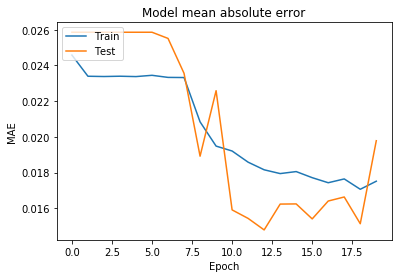

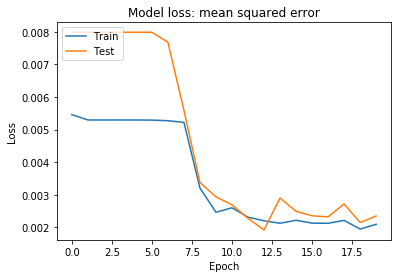

                      Municipio    Expected  Predicted      Error
0                   FÁTIMA (TO)    0.000000   0.000000   0.000000
1      SANTA CRUZ DO ARARI (PA)    0.000000   0.255837   0.255837
2             SERINGUEIRAS (RO)    6.869486   6.735953   0.133533
3                   PORTEL (PA)  107.897858  42.630909  65.266953
4    ALTA FLORESTA D'OESTE (RO)    5.045241   8.157173   3.111932
..                          ...         ...        ...        ...
755            SANTA LUZIA (MA)    1.311436   0.000000   1.311436
756               ALVORADA (TO)    0.000000   0.000000   0.000000
757       PONTES E LACERDA (MT)    2.124425   2.581730   0.457305
758       VITÓRIA DO XINGU (PA)   47.117195  14.744610  32.372585
759  SÃO FÉLIX DO ARAGUAIA (MT)   20.558084  17.903635   2.654449

[760 rows x 4 columns]
Muestra: 760 municipios
Error absoluto medio: 4.554159
Deforestación predicha: 4410.344591862522 
Deforestación real: 6050.168898411095 
Error (%): 27.10377733387288
Creando el modelo.

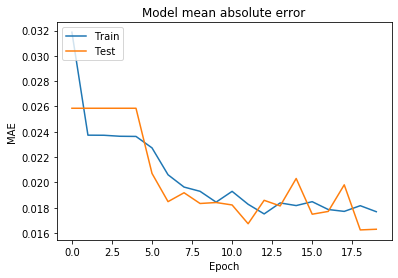

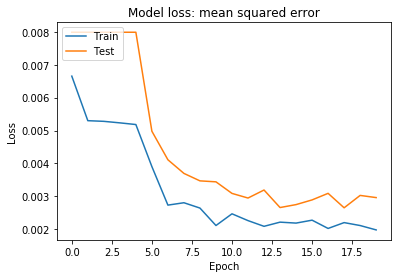

                      Municipio    Expected  Predicted      Error
0                   FÁTIMA (TO)    0.000000   0.000000   0.000000
1      SANTA CRUZ DO ARARI (PA)    0.000000   5.672704   5.672704
2             SERINGUEIRAS (RO)    6.869486  13.063692   6.194206
3                   PORTEL (PA)  107.897858  38.986309  68.911545
4    ALTA FLORESTA D'OESTE (RO)    5.045241  14.109668   9.064426
..                          ...         ...        ...        ...
755            SANTA LUZIA (MA)    1.311436   8.763746   7.452310
756               ALVORADA (TO)    0.000000   0.000000   0.000000
757       PONTES E LACERDA (MT)    2.124425   8.029669   5.905244
758       VITÓRIA DO XINGU (PA)   47.117195  11.717703  35.399490
759  SÃO FÉLIX DO ARAGUAIA (MT)   20.558084  22.699722   2.141638

[760 rows x 4 columns]
Muestra: 760 municipios
Error absoluto medio: 6.0970387
Deforestación predicha: 5636.007519856095 
Deforestación real: 6050.168898411095 
Error (%): 6.845451515638969
Creando el modelo


Epoch 00030: val_loss did not improve from 0.00216
Epoch 31/50
 - 2s - loss: 0.0017 - mae: 0.0158 - val_loss: 0.0025 - val_mae: 0.0152

Epoch 00031: val_loss did not improve from 0.00216
Epoch 32/50
 - 2s - loss: 0.0019 - mae: 0.0161 - val_loss: 0.0023 - val_mae: 0.0148

Epoch 00032: val_loss did not improve from 0.00216
Epoch 33/50
 - 2s - loss: 0.0016 - mae: 0.0160 - val_loss: 0.0026 - val_mae: 0.0153

Epoch 00033: val_loss did not improve from 0.00216
Epoch 34/50
 - 2s - loss: 0.0018 - mae: 0.0158 - val_loss: 0.0026 - val_mae: 0.0148

Epoch 00034: val_loss did not improve from 0.00216
Epoch 35/50
 - 2s - loss: 0.0016 - mae: 0.0158 - val_loss: 0.0021 - val_mae: 0.0142

Epoch 00035: val_loss improved from 0.00216 to 0.00215, saving model to modelos2/model_1_50_32_0.h5
Epoch 36/50
 - 2s - loss: 0.0018 - mae: 0.0158 - val_loss: 0.0023 - val_mae: 0.0157

Epoch 00036: val_loss did not improve from 0.00215
Epoch 37/50
 - 2s - loss: 0.0018 - mae: 0.0162 - val_loss: 0.0027 - val_mae: 0.0153

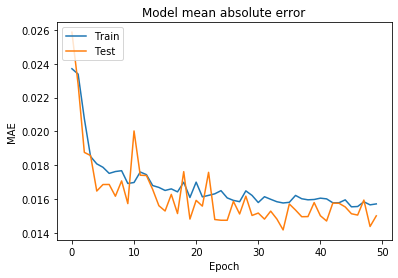

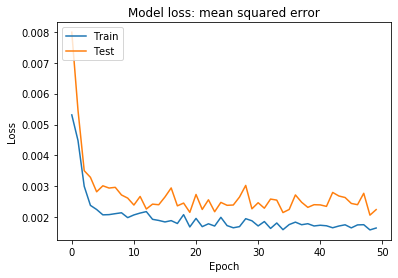

                      Municipio    Expected  Predicted      Error
0                   FÁTIMA (TO)    0.000000   0.000000   0.000000
1      SANTA CRUZ DO ARARI (PA)    0.000000   0.000000   0.000000
2             SERINGUEIRAS (RO)    6.869486   7.813464   0.943978
3                   PORTEL (PA)  107.897858  50.417805  57.480053
4    ALTA FLORESTA D'OESTE (RO)    5.045241   9.674263   4.629022
..                          ...         ...        ...        ...
755            SANTA LUZIA (MA)    1.311436   0.000000   1.311436
756               ALVORADA (TO)    0.000000   0.000000   0.000000
757       PONTES E LACERDA (MT)    2.124425   2.329760   0.205335
758       VITÓRIA DO XINGU (PA)   47.117195  13.837278  33.279915
759  SÃO FÉLIX DO ARAGUAIA (MT)   20.558084  20.953979   0.395895

[760 rows x 4 columns]
Muestra: 760 municipios
Error absoluto medio: 4.425248
Deforestación predicha: 3976.5011720098555 
Deforestación real: 6050.168898411095 
Error (%): 34.27454276434877
Creando el modelo

 - 1s - loss: 0.0018 - mae: 0.0160 - val_loss: 0.0022 - val_mae: 0.0147

Epoch 00031: val_loss did not improve from 0.00186
Epoch 32/50
 - 1s - loss: 0.0019 - mae: 0.0162 - val_loss: 0.0020 - val_mae: 0.0148

Epoch 00032: val_loss did not improve from 0.00186
Epoch 33/50
 - 1s - loss: 0.0017 - mae: 0.0159 - val_loss: 0.0021 - val_mae: 0.0155

Epoch 00033: val_loss did not improve from 0.00186
Epoch 34/50
 - 1s - loss: 0.0018 - mae: 0.0159 - val_loss: 0.0022 - val_mae: 0.0141

Epoch 00034: val_loss did not improve from 0.00186
Epoch 35/50
 - 1s - loss: 0.0019 - mae: 0.0167 - val_loss: 0.0022 - val_mae: 0.0150

Epoch 00035: val_loss did not improve from 0.00186
Epoch 36/50
 - 1s - loss: 0.0018 - mae: 0.0161 - val_loss: 0.0019 - val_mae: 0.0148

Epoch 00036: val_loss improved from 0.00186 to 0.00185, saving model to modelos2/model_1_50_64_0.h5
Epoch 37/50
 - 1s - loss: 0.0017 - mae: 0.0160 - val_loss: 0.0021 - val_mae: 0.0138

Epoch 00037: val_loss did not improve from 0.00185
Epoch 38/50

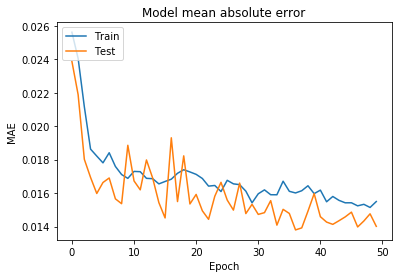

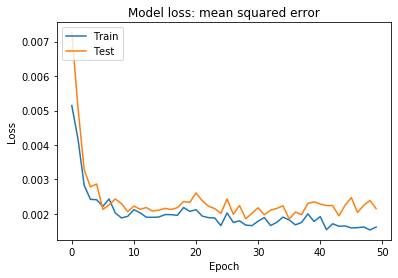

                      Municipio    Expected  Predicted      Error
0                   FÁTIMA (TO)    0.000000   0.000000   0.000000
1      SANTA CRUZ DO ARARI (PA)    0.000000   0.438228   0.438228
2             SERINGUEIRAS (RO)    6.869486   9.012457   2.142971
3                   PORTEL (PA)  107.897858  50.878593  57.019264
4    ALTA FLORESTA D'OESTE (RO)    5.045241  10.581527   5.536285
..                          ...         ...        ...        ...
755            SANTA LUZIA (MA)    1.311436  14.689747  13.378310
756               ALVORADA (TO)    0.000000   0.000000   0.000000
757       PONTES E LACERDA (MT)    2.124425   5.191557   3.067132
758       VITÓRIA DO XINGU (PA)   47.117195  14.630741  32.486454
759  SÃO FÉLIX DO ARAGUAIA (MT)   20.558084  22.534107   1.976023

[760 rows x 4 columns]
Muestra: 760 municipios
Error absoluto medio: 4.5509753
Deforestación predicha: 5130.645715326071 
Deforestación real: 6050.168898411095 
Error (%): 15.198306006407705
Creando el model

 - 2s - loss: 0.0020 - mae: 0.0170 - val_loss: 0.0024 - val_mae: 0.0160

Epoch 00030: val_loss did not improve from 0.00207
Epoch 31/100
 - 2s - loss: 0.0018 - mae: 0.0165 - val_loss: 0.0020 - val_mae: 0.0177

Epoch 00031: val_loss improved from 0.00207 to 0.00198, saving model to modelos2/model_1_100_32_0.h5
Epoch 32/100
 - 2s - loss: 0.0018 - mae: 0.0168 - val_loss: 0.0026 - val_mae: 0.0164

Epoch 00032: val_loss did not improve from 0.00198
Epoch 33/100
 - 2s - loss: 0.0019 - mae: 0.0167 - val_loss: 0.0023 - val_mae: 0.0152

Epoch 00033: val_loss did not improve from 0.00198
Epoch 34/100
 - 2s - loss: 0.0018 - mae: 0.0166 - val_loss: 0.0021 - val_mae: 0.0149

Epoch 00034: val_loss did not improve from 0.00198
Epoch 35/100
 - 2s - loss: 0.0020 - mae: 0.0169 - val_loss: 0.0025 - val_mae: 0.0153

Epoch 00035: val_loss did not improve from 0.00198
Epoch 36/100
 - 2s - loss: 0.0019 - mae: 0.0167 - val_loss: 0.0028 - val_mae: 0.0158

Epoch 00036: val_loss did not improve from 0.00198
Epoc

 - 2s - loss: 0.0017 - mae: 0.0155 - val_loss: 0.0023 - val_mae: 0.0148

Epoch 00089: val_loss did not improve from 0.00189
Epoch 90/100
 - 2s - loss: 0.0015 - mae: 0.0152 - val_loss: 0.0021 - val_mae: 0.0143

Epoch 00090: val_loss did not improve from 0.00189
Epoch 91/100
 - 2s - loss: 0.0016 - mae: 0.0154 - val_loss: 0.0022 - val_mae: 0.0145

Epoch 00091: val_loss did not improve from 0.00189
Epoch 92/100
 - 2s - loss: 0.0018 - mae: 0.0154 - val_loss: 0.0022 - val_mae: 0.0148

Epoch 00092: val_loss did not improve from 0.00189
Epoch 93/100
 - 2s - loss: 0.0017 - mae: 0.0157 - val_loss: 0.0025 - val_mae: 0.0156

Epoch 00093: val_loss did not improve from 0.00189
Epoch 94/100
 - 2s - loss: 0.0018 - mae: 0.0156 - val_loss: 0.0028 - val_mae: 0.0160

Epoch 00094: val_loss did not improve from 0.00189
Epoch 95/100
 - 2s - loss: 0.0016 - mae: 0.0153 - val_loss: 0.0024 - val_mae: 0.0149

Epoch 00095: val_loss did not improve from 0.00189
Epoch 96/100
 - 2s - loss: 0.0015 - mae: 0.0150 - val_

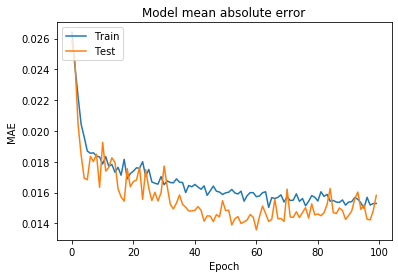

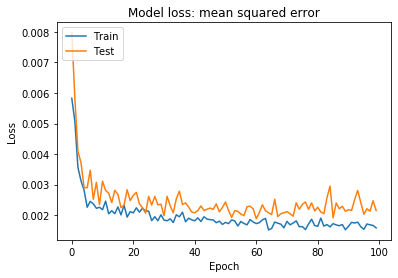

                      Municipio    Expected  Predicted      Error
0                   FÁTIMA (TO)    0.000000   0.000000   0.000000
1      SANTA CRUZ DO ARARI (PA)    0.000000   0.000000   0.000000
2             SERINGUEIRAS (RO)    6.869486   0.000000   6.869486
3                   PORTEL (PA)  107.897858  57.395954  50.501904
4    ALTA FLORESTA D'OESTE (RO)    5.045241   3.480458   1.564784
..                          ...         ...        ...        ...
755            SANTA LUZIA (MA)    1.311436  12.820187  11.508750
756               ALVORADA (TO)    0.000000   0.000000   0.000000
757       PONTES E LACERDA (MT)    2.124425   1.181346   0.943079
758       VITÓRIA DO XINGU (PA)   47.117195  10.736918  36.380276
759  SÃO FÉLIX DO ARAGUAIA (MT)   20.558084  20.264154   0.293930

[760 rows x 4 columns]
Muestra: 760 municipios
Error absoluto medio: 4.1773086
Deforestación predicha: 3867.929209649563 
Deforestación real: 6050.168898411095 
Error (%): 36.06907055660273
Creando el modelo


Epoch 00028: val_loss did not improve from 0.00210
Epoch 29/100
 - 1s - loss: 0.0021 - mae: 0.0173 - val_loss: 0.0021 - val_mae: 0.0161

Epoch 00029: val_loss improved from 0.00210 to 0.00207, saving model to modelos2/model_1_100_64_0.h5
Epoch 30/100
 - 1s - loss: 0.0019 - mae: 0.0168 - val_loss: 0.0022 - val_mae: 0.0145

Epoch 00030: val_loss did not improve from 0.00207
Epoch 31/100
 - 1s - loss: 0.0019 - mae: 0.0166 - val_loss: 0.0023 - val_mae: 0.0150

Epoch 00031: val_loss did not improve from 0.00207
Epoch 32/100
 - 1s - loss: 0.0019 - mae: 0.0164 - val_loss: 0.0023 - val_mae: 0.0174

Epoch 00032: val_loss did not improve from 0.00207
Epoch 33/100
 - 1s - loss: 0.0019 - mae: 0.0168 - val_loss: 0.0021 - val_mae: 0.0144

Epoch 00033: val_loss improved from 0.00207 to 0.00206, saving model to modelos2/model_1_100_64_0.h5
Epoch 34/100
 - 1s - loss: 0.0019 - mae: 0.0162 - val_loss: 0.0024 - val_mae: 0.0165

Epoch 00034: val_loss did not improve from 0.00206
Epoch 35/100
 - 1s - loss:


Epoch 00087: val_loss did not improve from 0.00181
Epoch 88/100
 - 1s - loss: 0.0015 - mae: 0.0153 - val_loss: 0.0022 - val_mae: 0.0141

Epoch 00088: val_loss did not improve from 0.00181
Epoch 89/100
 - 1s - loss: 0.0014 - mae: 0.0148 - val_loss: 0.0024 - val_mae: 0.0147

Epoch 00089: val_loss did not improve from 0.00181
Epoch 90/100
 - 1s - loss: 0.0015 - mae: 0.0150 - val_loss: 0.0023 - val_mae: 0.0145

Epoch 00090: val_loss did not improve from 0.00181
Epoch 91/100
 - 1s - loss: 0.0015 - mae: 0.0149 - val_loss: 0.0025 - val_mae: 0.0165

Epoch 00091: val_loss did not improve from 0.00181
Epoch 92/100
 - 1s - loss: 0.0015 - mae: 0.0148 - val_loss: 0.0023 - val_mae: 0.0144

Epoch 00092: val_loss did not improve from 0.00181
Epoch 93/100
 - 1s - loss: 0.0015 - mae: 0.0153 - val_loss: 0.0021 - val_mae: 0.0144

Epoch 00093: val_loss did not improve from 0.00181
Epoch 94/100
 - 1s - loss: 0.0015 - mae: 0.0149 - val_loss: 0.0023 - val_mae: 0.0151

Epoch 00094: val_loss did not improve fr

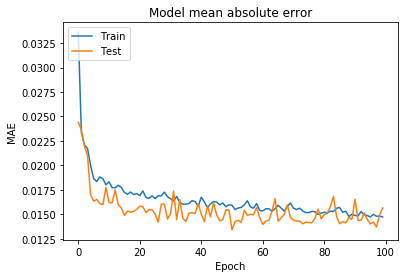

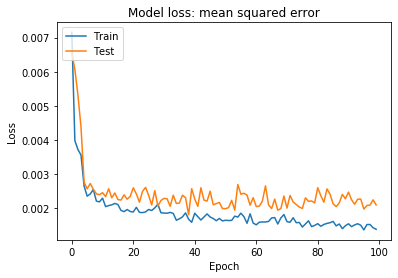

                      Municipio    Expected  Predicted      Error
0                   FÁTIMA (TO)    0.000000   0.000000   0.000000
1      SANTA CRUZ DO ARARI (PA)    0.000000   0.000000   0.000000
2             SERINGUEIRAS (RO)    6.869486   5.371440   1.498045
3                   PORTEL (PA)  107.897858  55.690922  52.206936
4    ALTA FLORESTA D'OESTE (RO)    5.045241   7.300889   2.255648
..                          ...         ...        ...        ...
755            SANTA LUZIA (MA)    1.311436   0.000000   1.311436
756               ALVORADA (TO)    0.000000   0.000000   0.000000
757       PONTES E LACERDA (MT)    2.124425   9.583917   7.459492
758       VITÓRIA DO XINGU (PA)   47.117195  16.772779  30.344416
759  SÃO FÉLIX DO ARAGUAIA (MT)   20.558084  25.894733   5.336649

[760 rows x 4 columns]
Muestra: 760 municipios
Error absoluto medio: 4.6445646
Deforestación predicha: 5219.903012724593 
Deforestación real: 6050.168898411095 
Error (%): 13.723019962377375
Creando el model

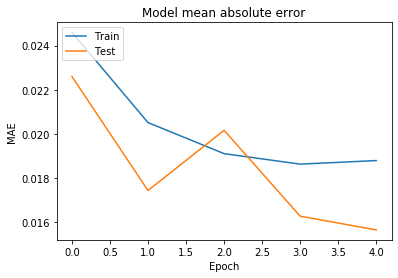

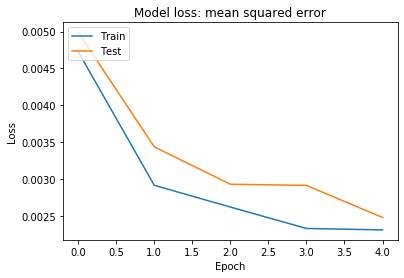

                      Municipio    Expected  Predicted      Error
0                   FÁTIMA (TO)    0.000000   0.000000   0.000000
1      SANTA CRUZ DO ARARI (PA)    0.000000   0.000000   0.000000
2             SERINGUEIRAS (RO)    6.869486   0.000000   6.869486
3                   PORTEL (PA)  107.897858  12.273705  95.624153
4    ALTA FLORESTA D'OESTE (RO)    5.045241   0.000000   5.045241
..                          ...         ...        ...        ...
755            SANTA LUZIA (MA)    1.311436   0.000000   1.311436
756               ALVORADA (TO)    0.000000   0.000000   0.000000
757       PONTES E LACERDA (MT)    2.124425   0.748572   1.375853
758       VITÓRIA DO XINGU (PA)   47.117195   2.643282  44.473915
759  SÃO FÉLIX DO ARAGUAIA (MT)   20.558084   9.550611  11.007473

[760 rows x 4 columns]
Muestra: 760 municipios
Error absoluto medio: 4.8106503
Deforestación predicha: 2998.844118738547 
Deforestación real: 6050.168898411095 
Error (%): 50.43371236254068
Creando el modelo

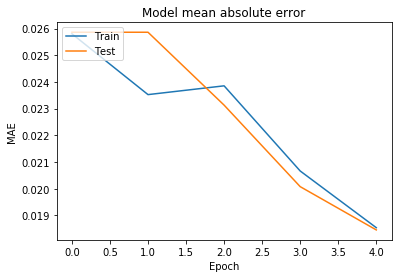

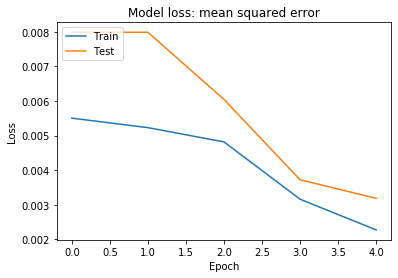

                      Municipio    Expected  Predicted      Error
0                   FÁTIMA (TO)    0.000000   0.000000   0.000000
1      SANTA CRUZ DO ARARI (PA)    0.000000   2.843454   2.843454
2             SERINGUEIRAS (RO)    6.869486   0.000000   6.869486
3                   PORTEL (PA)  107.897858  23.328474  84.569382
4    ALTA FLORESTA D'OESTE (RO)    5.045241   0.000000   5.045241
..                          ...         ...        ...        ...
755            SANTA LUZIA (MA)    1.311436   0.000000   1.311436
756               ALVORADA (TO)    0.000000   0.000000   0.000000
757       PONTES E LACERDA (MT)    2.124425  10.435983   8.311558
758       VITÓRIA DO XINGU (PA)   47.117195  11.672794  35.444401
759  SÃO FÉLIX DO ARAGUAIA (MT)   20.558084  24.255995   3.697910

[760 rows x 4 columns]
Muestra: 760 municipios
Error absoluto medio: 5.6814556
Deforestación predicha: 3765.5214646197855 
Deforestación real: 6050.168898411095 
Error (%): 37.761713303430376
Creando el mode

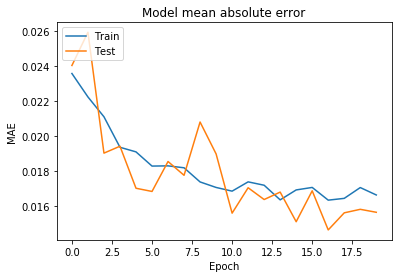

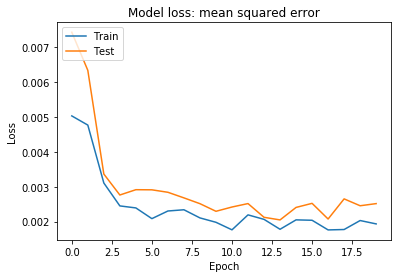

                      Municipio    Expected  Predicted      Error
0                   FÁTIMA (TO)    0.000000   0.000000   0.000000
1      SANTA CRUZ DO ARARI (PA)    0.000000   4.514841   4.514841
2             SERINGUEIRAS (RO)    6.869486  12.006560   5.137074
3                   PORTEL (PA)  107.897858  37.430851  70.467010
4    ALTA FLORESTA D'OESTE (RO)    5.045241  12.784427   7.739185
..                          ...         ...        ...        ...
755            SANTA LUZIA (MA)    1.311436   0.000000   1.311436
756               ALVORADA (TO)    0.000000   0.000000   0.000000
757       PONTES E LACERDA (MT)    2.124425   5.503943   3.379519
758       VITÓRIA DO XINGU (PA)   47.117195  13.540517  33.576679
759  SÃO FÉLIX DO ARAGUAIA (MT)   20.558084  13.484896   7.073189

[760 rows x 4 columns]
Muestra: 760 municipios
Error absoluto medio: 5.1772137
Deforestación predicha: 5179.958399370313 
Deforestación real: 6050.168898411095 
Error (%): 14.383243073913498
Creando el model

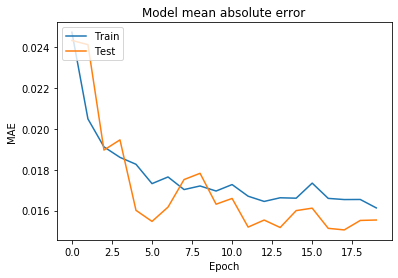

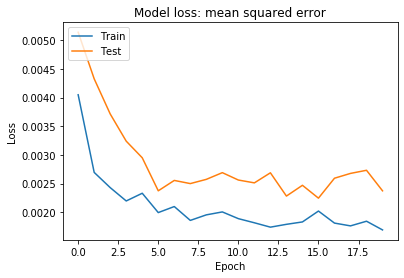

                      Municipio    Expected  Predicted      Error
0                   FÁTIMA (TO)    0.000000   0.000000   0.000000
1      SANTA CRUZ DO ARARI (PA)    0.000000   1.603298   1.603298
2             SERINGUEIRAS (RO)    6.869486   8.509714   1.640228
3                   PORTEL (PA)  107.897858  38.172005  69.725853
4    ALTA FLORESTA D'OESTE (RO)    5.045241   7.727933   2.682692
..                          ...         ...        ...        ...
755            SANTA LUZIA (MA)    1.311436  10.793112   9.481675
756               ALVORADA (TO)    0.000000   0.000000   0.000000
757       PONTES E LACERDA (MT)    2.124425   8.003036   5.878612
758       VITÓRIA DO XINGU (PA)   47.117195  18.191362  28.925833
759  SÃO FÉLIX DO ARAGUAIA (MT)   20.558084  23.675179   3.117094

[760 rows x 4 columns]
Muestra: 760 municipios
Error absoluto medio: 4.962141
Deforestación predicha: 5098.640644725412 
Deforestación real: 6050.168898411095 
Error (%): 15.727300669830472
Creando el modelo


Epoch 00028: val_loss did not improve from 0.00191
Epoch 29/50
 - 2s - loss: 0.0018 - mae: 0.0165 - val_loss: 0.0021 - val_mae: 0.0172

Epoch 00029: val_loss did not improve from 0.00191
Epoch 30/50
 - 2s - loss: 0.0019 - mae: 0.0164 - val_loss: 0.0025 - val_mae: 0.0186

Epoch 00030: val_loss did not improve from 0.00191
Epoch 31/50
 - 2s - loss: 0.0018 - mae: 0.0165 - val_loss: 0.0023 - val_mae: 0.0146

Epoch 00031: val_loss did not improve from 0.00191
Epoch 32/50
 - 2s - loss: 0.0018 - mae: 0.0163 - val_loss: 0.0024 - val_mae: 0.0171

Epoch 00032: val_loss did not improve from 0.00191
Epoch 33/50
 - 2s - loss: 0.0018 - mae: 0.0163 - val_loss: 0.0024 - val_mae: 0.0187

Epoch 00033: val_loss did not improve from 0.00191
Epoch 34/50
 - 2s - loss: 0.0020 - mae: 0.0166 - val_loss: 0.0023 - val_mae: 0.0157

Epoch 00034: val_loss did not improve from 0.00191
Epoch 35/50
 - 2s - loss: 0.0017 - mae: 0.0161 - val_loss: 0.0025 - val_mae: 0.0150

Epoch 00035: val_loss did not improve from 0.00

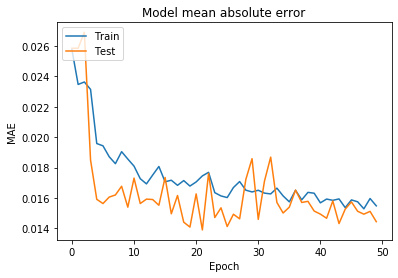

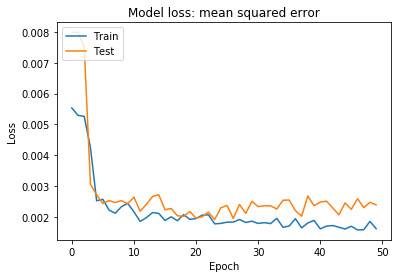

                      Municipio    Expected  Predicted      Error
0                   FÁTIMA (TO)    0.000000   0.000000   0.000000
1      SANTA CRUZ DO ARARI (PA)    0.000000   0.000000   0.000000
2             SERINGUEIRAS (RO)    6.869486   4.775058   2.094428
3                   PORTEL (PA)  107.897858  44.939976  62.957882
4    ALTA FLORESTA D'OESTE (RO)    5.045241   7.489011   2.443770
..                          ...         ...        ...        ...
755            SANTA LUZIA (MA)    1.311436   9.749734   8.438297
756               ALVORADA (TO)    0.000000   0.000000   0.000000
757       PONTES E LACERDA (MT)    2.124425   0.000000   2.124425
758       VITÓRIA DO XINGU (PA)   47.117195  15.998384  31.118813
759  SÃO FÉLIX DO ARAGUAIA (MT)   20.558084  20.433107   0.124977

[760 rows x 4 columns]
Muestra: 760 municipios
Error absoluto medio: 4.528968
Deforestación predicha: 4744.6369409784675 
Deforestación real: 6050.168898411095 
Error (%): 21.57843821146032
Creando el modelo

 - 1s - loss: 0.0020 - mae: 0.0167 - val_loss: 0.0025 - val_mae: 0.0154

Epoch 00029: val_loss improved from 0.00254 to 0.00247, saving model to modelos2/model_2_50_64_0.h5
Epoch 30/50
 - 1s - loss: 0.0018 - mae: 0.0164 - val_loss: 0.0024 - val_mae: 0.0145

Epoch 00030: val_loss improved from 0.00247 to 0.00240, saving model to modelos2/model_2_50_64_0.h5
Epoch 31/50
 - 1s - loss: 0.0019 - mae: 0.0165 - val_loss: 0.0026 - val_mae: 0.0152

Epoch 00031: val_loss did not improve from 0.00240
Epoch 32/50
 - 1s - loss: 0.0017 - mae: 0.0158 - val_loss: 0.0029 - val_mae: 0.0159

Epoch 00032: val_loss did not improve from 0.00240
Epoch 33/50
 - 1s - loss: 0.0017 - mae: 0.0156 - val_loss: 0.0025 - val_mae: 0.0154

Epoch 00033: val_loss did not improve from 0.00240
Epoch 34/50
 - 1s - loss: 0.0016 - mae: 0.0157 - val_loss: 0.0024 - val_mae: 0.0149

Epoch 00034: val_loss improved from 0.00240 to 0.00240, saving model to modelos2/model_2_50_64_0.h5
Epoch 35/50
 - 1s - loss: 0.0015 - mae: 0.0156 - 

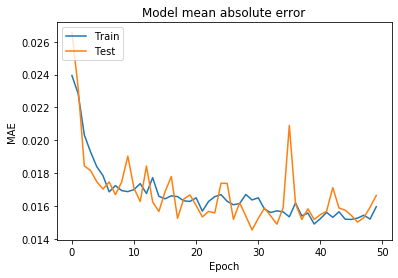

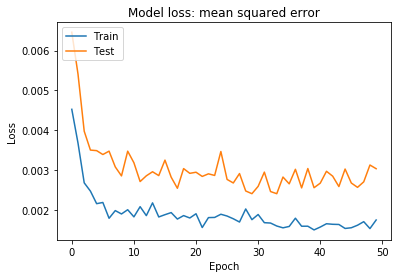

                      Municipio    Expected  Predicted      Error
0                   FÁTIMA (TO)    0.000000   0.000000   0.000000
1      SANTA CRUZ DO ARARI (PA)    0.000000   0.000000   0.000000
2             SERINGUEIRAS (RO)    6.869486   3.376393   3.493093
3                   PORTEL (PA)  107.897858  49.707573  58.190285
4    ALTA FLORESTA D'OESTE (RO)    5.045241   4.988924   0.056317
..                          ...         ...        ...        ...
755            SANTA LUZIA (MA)    1.311436   0.000000   1.311436
756               ALVORADA (TO)    0.000000   0.000000   0.000000
757       PONTES E LACERDA (MT)    2.124425   0.000000   2.124425
758       VITÓRIA DO XINGU (PA)   47.117195   7.744125  39.373070
759  SÃO FÉLIX DO ARAGUAIA (MT)   20.558084  20.055317   0.502768

[760 rows x 4 columns]
Muestra: 760 municipios
Error absoluto medio: 4.582759
Deforestación predicha: 3720.345756240189 
Deforestación real: 6050.168898411095 
Error (%): 38.508398381783486
Creando el modelo


Epoch 00029: val_loss did not improve from 0.00210
Epoch 30/100
 - 2s - loss: 0.0017 - mae: 0.0164 - val_loss: 0.0025 - val_mae: 0.0183

Epoch 00030: val_loss did not improve from 0.00210
Epoch 31/100
 - 2s - loss: 0.0017 - mae: 0.0162 - val_loss: 0.0027 - val_mae: 0.0164

Epoch 00031: val_loss did not improve from 0.00210
Epoch 32/100
 - 2s - loss: 0.0016 - mae: 0.0160 - val_loss: 0.0024 - val_mae: 0.0164

Epoch 00032: val_loss did not improve from 0.00210
Epoch 33/100
 - 2s - loss: 0.0016 - mae: 0.0159 - val_loss: 0.0024 - val_mae: 0.0194

Epoch 00033: val_loss did not improve from 0.00210
Epoch 34/100
 - 2s - loss: 0.0017 - mae: 0.0164 - val_loss: 0.0026 - val_mae: 0.0151

Epoch 00034: val_loss did not improve from 0.00210
Epoch 35/100
 - 2s - loss: 0.0016 - mae: 0.0159 - val_loss: 0.0023 - val_mae: 0.0186

Epoch 00035: val_loss did not improve from 0.00210
Epoch 36/100
 - 2s - loss: 0.0016 - mae: 0.0160 - val_loss: 0.0028 - val_mae: 0.0162

Epoch 00036: val_loss did not improve fr


Epoch 00089: val_loss did not improve from 0.00210
Epoch 90/100
 - 2s - loss: 0.0014 - mae: 0.0146 - val_loss: 0.0022 - val_mae: 0.0155

Epoch 00090: val_loss did not improve from 0.00210
Epoch 91/100
 - 2s - loss: 0.0014 - mae: 0.0146 - val_loss: 0.0022 - val_mae: 0.0150

Epoch 00091: val_loss did not improve from 0.00210
Epoch 92/100
 - 2s - loss: 0.0015 - mae: 0.0150 - val_loss: 0.0024 - val_mae: 0.0169

Epoch 00092: val_loss did not improve from 0.00210
Epoch 93/100
 - 2s - loss: 0.0014 - mae: 0.0144 - val_loss: 0.0034 - val_mae: 0.0171

Epoch 00093: val_loss did not improve from 0.00210
Epoch 94/100
 - 2s - loss: 0.0014 - mae: 0.0145 - val_loss: 0.0027 - val_mae: 0.0164

Epoch 00094: val_loss did not improve from 0.00210
Epoch 95/100
 - 2s - loss: 0.0014 - mae: 0.0147 - val_loss: 0.0024 - val_mae: 0.0148

Epoch 00095: val_loss did not improve from 0.00210
Epoch 96/100
 - 2s - loss: 0.0014 - mae: 0.0144 - val_loss: 0.0029 - val_mae: 0.0163

Epoch 00096: val_loss did not improve fr

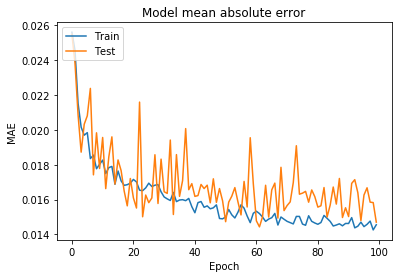

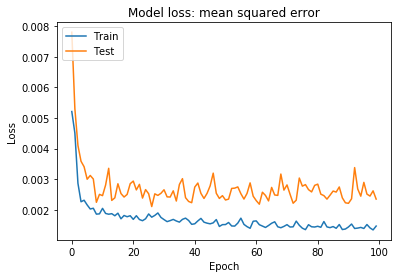

                      Municipio    Expected  Predicted      Error
0                   FÁTIMA (TO)    0.000000   0.000000   0.000000
1      SANTA CRUZ DO ARARI (PA)    0.000000   3.230700   3.230700
2             SERINGUEIRAS (RO)    6.869486   6.212491   0.656995
3                   PORTEL (PA)  107.897858  60.244911  47.652946
4    ALTA FLORESTA D'OESTE (RO)    5.045241   7.469730   2.424489
..                          ...         ...        ...        ...
755            SANTA LUZIA (MA)    1.311436   8.049444   6.738008
756               ALVORADA (TO)    0.000000   0.000000   0.000000
757       PONTES E LACERDA (MT)    2.124425   4.730626   2.606201
758       VITÓRIA DO XINGU (PA)   47.117195  19.678259  27.438936
759  SÃO FÉLIX DO ARAGUAIA (MT)   20.558084  21.377008   0.818924

[760 rows x 4 columns]
Muestra: 760 municipios
Error absoluto medio: 4.9539447
Deforestación predicha: 5247.372915647924 
Deforestación real: 6050.168898411095 
Error (%): 13.268984655519331
Creando el model

 - 1s - loss: 0.0016 - mae: 0.0161 - val_loss: 0.0024 - val_mae: 0.0156

Epoch 00028: val_loss did not improve from 0.00215
Epoch 29/100
 - 1s - loss: 0.0017 - mae: 0.0164 - val_loss: 0.0023 - val_mae: 0.0153

Epoch 00029: val_loss did not improve from 0.00215
Epoch 30/100
 - 1s - loss: 0.0016 - mae: 0.0162 - val_loss: 0.0021 - val_mae: 0.0156

Epoch 00030: val_loss improved from 0.00215 to 0.00212, saving model to modelos2/model_2_100_64_0.h5
Epoch 31/100
 - 1s - loss: 0.0017 - mae: 0.0164 - val_loss: 0.0025 - val_mae: 0.0152

Epoch 00031: val_loss did not improve from 0.00212
Epoch 32/100
 - 1s - loss: 0.0017 - mae: 0.0166 - val_loss: 0.0022 - val_mae: 0.0153

Epoch 00032: val_loss did not improve from 0.00212
Epoch 33/100
 - 1s - loss: 0.0018 - mae: 0.0164 - val_loss: 0.0028 - val_mae: 0.0159

Epoch 00033: val_loss did not improve from 0.00212
Epoch 34/100
 - 1s - loss: 0.0017 - mae: 0.0166 - val_loss: 0.0023 - val_mae: 0.0155

Epoch 00034: val_loss did not improve from 0.00212
Epoc

 - 1s - loss: 0.0015 - mae: 0.0150 - val_loss: 0.0021 - val_mae: 0.0150

Epoch 00087: val_loss did not improve from 0.00202
Epoch 88/100
 - 1s - loss: 0.0017 - mae: 0.0157 - val_loss: 0.0025 - val_mae: 0.0149

Epoch 00088: val_loss did not improve from 0.00202
Epoch 89/100
 - 1s - loss: 0.0015 - mae: 0.0151 - val_loss: 0.0022 - val_mae: 0.0146

Epoch 00089: val_loss did not improve from 0.00202
Epoch 90/100
 - 1s - loss: 0.0015 - mae: 0.0147 - val_loss: 0.0023 - val_mae: 0.0144

Epoch 00090: val_loss did not improve from 0.00202
Epoch 91/100
 - 1s - loss: 0.0016 - mae: 0.0151 - val_loss: 0.0022 - val_mae: 0.0153

Epoch 00091: val_loss did not improve from 0.00202
Epoch 92/100
 - 1s - loss: 0.0015 - mae: 0.0148 - val_loss: 0.0028 - val_mae: 0.0164

Epoch 00092: val_loss did not improve from 0.00202
Epoch 93/100
 - 1s - loss: 0.0015 - mae: 0.0152 - val_loss: 0.0028 - val_mae: 0.0155

Epoch 00093: val_loss did not improve from 0.00202
Epoch 94/100
 - 1s - loss: 0.0014 - mae: 0.0149 - val_

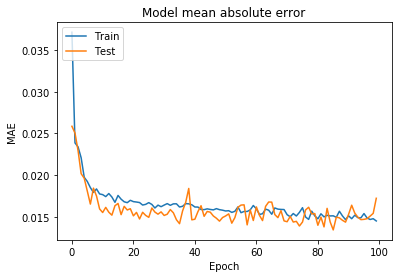

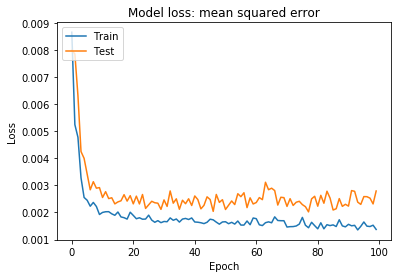

                      Municipio    Expected  Predicted      Error
0                   FÁTIMA (TO)    0.000000   0.000000   0.000000
1      SANTA CRUZ DO ARARI (PA)    0.000000   3.987907   3.987907
2             SERINGUEIRAS (RO)    6.869486   7.556495   0.687009
3                   PORTEL (PA)  107.897858  61.980167  45.917690
4    ALTA FLORESTA D'OESTE (RO)    5.045241   9.171445   4.126204
..                          ...         ...        ...        ...
755            SANTA LUZIA (MA)    1.311436   0.604915   0.706522
756               ALVORADA (TO)    0.000000   0.000000   0.000000
757       PONTES E LACERDA (MT)    2.124425   2.178105   0.053680
758       VITÓRIA DO XINGU (PA)   47.117195  28.004602  19.112593
759  SÃO FÉLIX DO ARAGUAIA (MT)   20.558084  25.596390   5.038305

[760 rows x 4 columns]
Muestra: 760 municipios
Error absoluto medio: 4.9785686
Deforestación predicha: 5742.477349162102 
Deforestación real: 6050.168898411095 
Error (%): 5.085668754302047
Creando el modelo

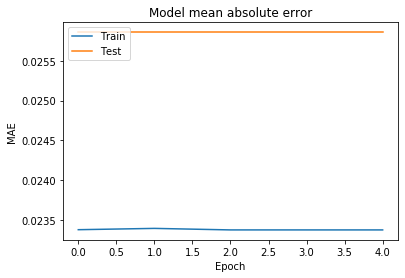

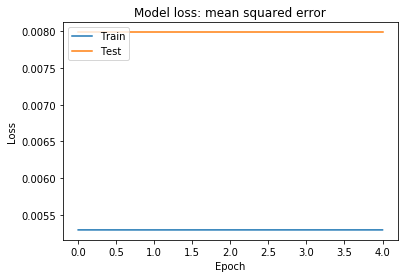

                      Municipio    Expected  Predicted       Error
0                   FÁTIMA (TO)    0.000000        0.0    0.000000
1      SANTA CRUZ DO ARARI (PA)    0.000000        0.0    0.000000
2             SERINGUEIRAS (RO)    6.869486        0.0    6.869486
3                   PORTEL (PA)  107.897858        0.0  107.897858
4    ALTA FLORESTA D'OESTE (RO)    5.045241        0.0    5.045241
..                          ...         ...        ...         ...
755            SANTA LUZIA (MA)    1.311436        0.0    1.311436
756               ALVORADA (TO)    0.000000        0.0    0.000000
757       PONTES E LACERDA (MT)    2.124425        0.0    2.124425
758       VITÓRIA DO XINGU (PA)   47.117195        0.0   47.117195
759  SÃO FÉLIX DO ARAGUAIA (MT)   20.558084        0.0   20.558084

[760 rows x 4 columns]
Muestra: 760 municipios
Error absoluto medio: 7.9607487
Deforestación predicha: 0.0 
Deforestación real: 6050.168898411095 
Error (%): 100.0
Creando el modelo...
	Capas int

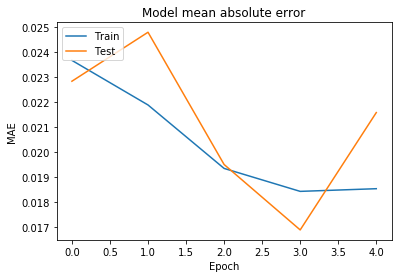

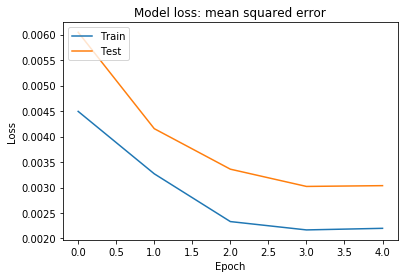

                      Municipio    Expected  Predicted      Error
0                   FÁTIMA (TO)    0.000000   0.000000   0.000000
1      SANTA CRUZ DO ARARI (PA)    0.000000   0.000000   0.000000
2             SERINGUEIRAS (RO)    6.869486   6.415160   0.454326
3                   PORTEL (PA)  107.897858  28.767603  79.130257
4    ALTA FLORESTA D'OESTE (RO)    5.045241   7.342730   2.297489
..                          ...         ...        ...        ...
755            SANTA LUZIA (MA)    1.311436   0.000000   1.311436
756               ALVORADA (TO)    0.000000   0.000000   0.000000
757       PONTES E LACERDA (MT)    2.124425  12.782745  10.658320
758       VITÓRIA DO XINGU (PA)   47.117195   9.145503  37.971691
759  SÃO FÉLIX DO ARAGUAIA (MT)   20.558084  17.629002   2.929083

[760 rows x 4 columns]
Muestra: 760 municipios
Error absoluto medio: 5.20023
Deforestación predicha: 3805.64007576555 
Deforestación real: 6050.168898411095 
Error (%): 37.098614275628016
Creando el modelo..

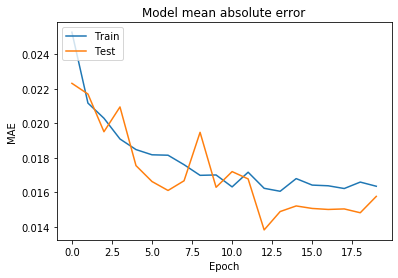

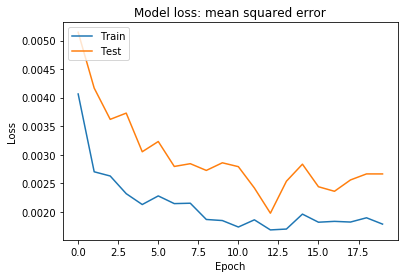

                      Municipio    Expected  Predicted      Error
0                   FÁTIMA (TO)    0.000000   0.000000   0.000000
1      SANTA CRUZ DO ARARI (PA)    0.000000   0.000000   0.000000
2             SERINGUEIRAS (RO)    6.869486   6.673822   0.195664
3                   PORTEL (PA)  107.897858  35.656906  72.240952
4    ALTA FLORESTA D'OESTE (RO)    5.045241   7.795565   2.750323
..                          ...         ...        ...        ...
755            SANTA LUZIA (MA)    1.311436  10.559579   9.248142
756               ALVORADA (TO)    0.000000   0.000000   0.000000
757       PONTES E LACERDA (MT)    2.124425   0.000000   2.124425
758       VITÓRIA DO XINGU (PA)   47.117195   6.067544  41.049652
759  SÃO FÉLIX DO ARAGUAIA (MT)   20.558084  21.899694   1.341610

[760 rows x 4 columns]
Muestra: 760 municipios
Error absoluto medio: 4.254908
Deforestación predicha: 4402.990703455638 
Deforestación real: 6050.168898411095 
Error (%): 27.22532581508661
Creando el modelo.

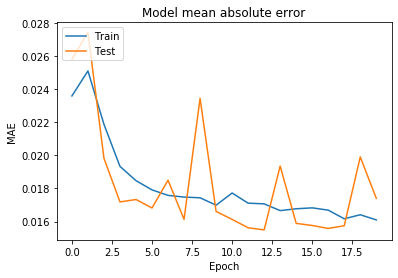

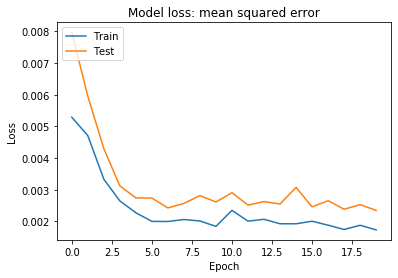

                      Municipio    Expected  Predicted      Error
0                   FÁTIMA (TO)    0.000000   0.000000   0.000000
1      SANTA CRUZ DO ARARI (PA)    0.000000   0.676843   0.676843
2             SERINGUEIRAS (RO)    6.869486   7.774282   0.904796
3                   PORTEL (PA)  107.897858  59.168091  48.729767
4    ALTA FLORESTA D'OESTE (RO)    5.045241   8.934541   3.889299
..                          ...         ...        ...        ...
755            SANTA LUZIA (MA)    1.311436   0.000000   1.311436
756               ALVORADA (TO)    0.000000   0.000000   0.000000
757       PONTES E LACERDA (MT)    2.124425   7.277734   5.153310
758       VITÓRIA DO XINGU (PA)   47.117195  17.927401  29.189795
759  SÃO FÉLIX DO ARAGUAIA (MT)   20.558084  30.578054  10.019970

[760 rows x 4 columns]
Muestra: 760 municipios
Error absoluto medio: 5.3574786
Deforestación predicha: 5685.729264318943 
Deforestación real: 6050.168898411095 
Error (%): 6.0236274426629945
Creando el model


Epoch 00027: val_loss improved from 0.00194 to 0.00171, saving model to modelos2/model_3_50_32_0.h5
Epoch 28/50
 - 2s - loss: 0.0018 - mae: 0.0166 - val_loss: 0.0023 - val_mae: 0.0161

Epoch 00028: val_loss did not improve from 0.00171
Epoch 29/50
 - 2s - loss: 0.0018 - mae: 0.0163 - val_loss: 0.0025 - val_mae: 0.0153

Epoch 00029: val_loss did not improve from 0.00171
Epoch 30/50
 - 2s - loss: 0.0016 - mae: 0.0159 - val_loss: 0.0024 - val_mae: 0.0147

Epoch 00030: val_loss did not improve from 0.00171
Epoch 31/50
 - 2s - loss: 0.0018 - mae: 0.0162 - val_loss: 0.0023 - val_mae: 0.0146

Epoch 00031: val_loss did not improve from 0.00171
Epoch 32/50
 - 2s - loss: 0.0016 - mae: 0.0159 - val_loss: 0.0022 - val_mae: 0.0149

Epoch 00032: val_loss did not improve from 0.00171
Epoch 33/50
 - 2s - loss: 0.0017 - mae: 0.0160 - val_loss: 0.0020 - val_mae: 0.0136

Epoch 00033: val_loss did not improve from 0.00171
Epoch 34/50
 - 2s - loss: 0.0017 - mae: 0.0159 - val_loss: 0.0031 - val_mae: 0.0158

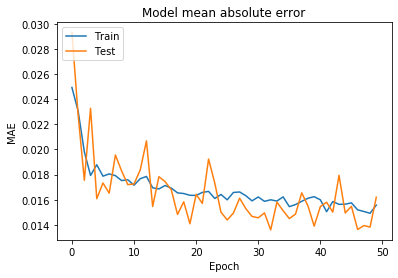

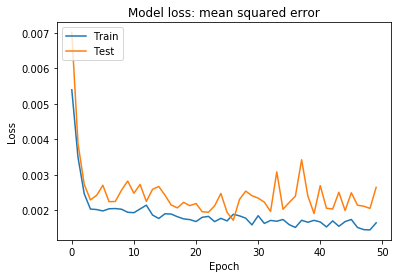

                      Municipio    Expected  Predicted      Error
0                   FÁTIMA (TO)    0.000000   0.000000   0.000000
1      SANTA CRUZ DO ARARI (PA)    0.000000   0.000000   0.000000
2             SERINGUEIRAS (RO)    6.869486   6.924788   0.055303
3                   PORTEL (PA)  107.897858  60.186172  47.711685
4    ALTA FLORESTA D'OESTE (RO)    5.045241   8.872025   3.826783
..                          ...         ...        ...        ...
755            SANTA LUZIA (MA)    1.311436  10.158324   8.846888
756               ALVORADA (TO)    0.000000   0.000000   0.000000
757       PONTES E LACERDA (MT)    2.124425   3.033906   0.909482
758       VITÓRIA DO XINGU (PA)   47.117195  11.226541  35.890656
759  SÃO FÉLIX DO ARAGUAIA (MT)   20.558084  26.290607   5.732523

[760 rows x 4 columns]
Muestra: 760 municipios
Error absoluto medio: 4.598092
Deforestación predicha: 5824.318217618158 
Deforestación real: 6050.168898411095 
Error (%): 3.732964890488434
Creando el modelo.

 - 1s - loss: 0.0016 - mae: 0.0159 - val_loss: 0.0021 - val_mae: 0.0176

Epoch 00027: val_loss did not improve from 0.00167
Epoch 28/50
 - 1s - loss: 0.0017 - mae: 0.0158 - val_loss: 0.0023 - val_mae: 0.0150

Epoch 00028: val_loss did not improve from 0.00167
Epoch 29/50
 - 1s - loss: 0.0017 - mae: 0.0157 - val_loss: 0.0025 - val_mae: 0.0150

Epoch 00029: val_loss did not improve from 0.00167
Epoch 30/50
 - 1s - loss: 0.0019 - mae: 0.0161 - val_loss: 0.0023 - val_mae: 0.0142

Epoch 00030: val_loss did not improve from 0.00167
Epoch 31/50
 - 1s - loss: 0.0018 - mae: 0.0159 - val_loss: 0.0023 - val_mae: 0.0152

Epoch 00031: val_loss did not improve from 0.00167
Epoch 32/50
 - 1s - loss: 0.0017 - mae: 0.0159 - val_loss: 0.0022 - val_mae: 0.0165

Epoch 00032: val_loss did not improve from 0.00167
Epoch 33/50
 - 1s - loss: 0.0018 - mae: 0.0160 - val_loss: 0.0019 - val_mae: 0.0189

Epoch 00033: val_loss did not improve from 0.00167
Epoch 34/50
 - 1s - loss: 0.0016 - mae: 0.0156 - val_loss: 0

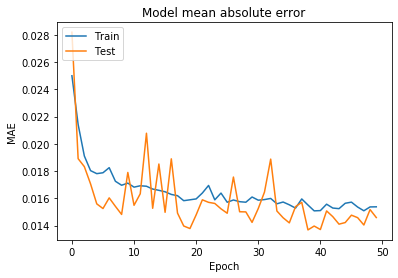

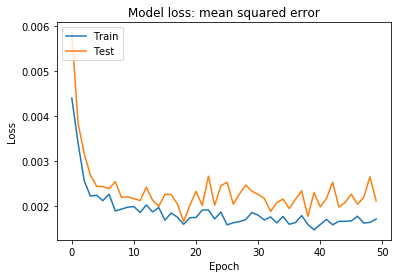

                      Municipio    Expected  Predicted      Error
0                   FÁTIMA (TO)    0.000000   0.000000   0.000000
1      SANTA CRUZ DO ARARI (PA)    0.000000   0.000000   0.000000
2             SERINGUEIRAS (RO)    6.869486   5.766912   1.102574
3                   PORTEL (PA)  107.897858  50.349628  57.548229
4    ALTA FLORESTA D'OESTE (RO)    5.045241   5.170971   0.125730
..                          ...         ...        ...        ...
755            SANTA LUZIA (MA)    1.311436   7.797930   6.486493
756               ALVORADA (TO)    0.000000   0.000000   0.000000
757       PONTES E LACERDA (MT)    2.124425   7.781310   5.656885
758       VITÓRIA DO XINGU (PA)   47.117195  13.636087  33.481110
759  SÃO FÉLIX DO ARAGUAIA (MT)   20.558084  18.947721   1.610363

[760 rows x 4 columns]
Muestra: 760 municipios
Error absoluto medio: 4.299251
Deforestación predicha: 5048.958491206169 
Deforestación real: 6050.168898411095 
Error (%): 16.5484703653127
Creando el modelo..


Epoch 00027: val_loss improved from 0.00213 to 0.00194, saving model to modelos2/model_3_100_32_0.h5
Epoch 28/100
 - 2s - loss: 0.0016 - mae: 0.0152 - val_loss: 0.0035 - val_mae: 0.0171

Epoch 00028: val_loss did not improve from 0.00194
Epoch 29/100
 - 2s - loss: 0.0017 - mae: 0.0160 - val_loss: 0.0028 - val_mae: 0.0155

Epoch 00029: val_loss did not improve from 0.00194
Epoch 30/100
 - 2s - loss: 0.0017 - mae: 0.0157 - val_loss: 0.0024 - val_mae: 0.0160

Epoch 00030: val_loss did not improve from 0.00194
Epoch 31/100
 - 2s - loss: 0.0016 - mae: 0.0153 - val_loss: 0.0023 - val_mae: 0.0149

Epoch 00031: val_loss did not improve from 0.00194
Epoch 32/100
 - 2s - loss: 0.0017 - mae: 0.0159 - val_loss: 0.0022 - val_mae: 0.0155

Epoch 00032: val_loss did not improve from 0.00194
Epoch 33/100
 - 2s - loss: 0.0017 - mae: 0.0153 - val_loss: 0.0022 - val_mae: 0.0154

Epoch 00033: val_loss did not improve from 0.00194
Epoch 34/100
 - 2s - loss: 0.0018 - mae: 0.0156 - val_loss: 0.0027 - val_mae

 - 2s - loss: 0.0015 - mae: 0.0149 - val_loss: 0.0026 - val_mae: 0.0149

Epoch 00087: val_loss did not improve from 0.00194
Epoch 88/100
 - 2s - loss: 0.0014 - mae: 0.0143 - val_loss: 0.0031 - val_mae: 0.0160

Epoch 00088: val_loss did not improve from 0.00194
Epoch 89/100
 - 2s - loss: 0.0014 - mae: 0.0142 - val_loss: 0.0025 - val_mae: 0.0161

Epoch 00089: val_loss did not improve from 0.00194
Epoch 90/100
 - 2s - loss: 0.0013 - mae: 0.0144 - val_loss: 0.0026 - val_mae: 0.0154

Epoch 00090: val_loss did not improve from 0.00194
Epoch 91/100
 - 2s - loss: 0.0013 - mae: 0.0139 - val_loss: 0.0028 - val_mae: 0.0153

Epoch 00091: val_loss did not improve from 0.00194
Epoch 92/100
 - 2s - loss: 0.0013 - mae: 0.0139 - val_loss: 0.0027 - val_mae: 0.0172

Epoch 00092: val_loss did not improve from 0.00194
Epoch 93/100
 - 2s - loss: 0.0012 - mae: 0.0137 - val_loss: 0.0024 - val_mae: 0.0147

Epoch 00093: val_loss did not improve from 0.00194
Epoch 94/100
 - 2s - loss: 0.0015 - mae: 0.0145 - val_

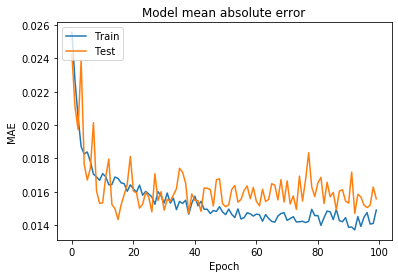

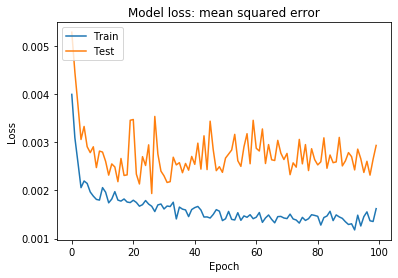

                      Municipio    Expected  Predicted      Error
0                   FÁTIMA (TO)    0.000000   0.000000   0.000000
1      SANTA CRUZ DO ARARI (PA)    0.000000   0.000000   0.000000
2             SERINGUEIRAS (RO)    6.869486   6.442904   0.426581
3                   PORTEL (PA)  107.897858  52.488819  55.409039
4    ALTA FLORESTA D'OESTE (RO)    5.045241  11.879327   6.834085
..                          ...         ...        ...        ...
755            SANTA LUZIA (MA)    1.311436  15.000653  13.689217
756               ALVORADA (TO)    0.000000   0.000000   0.000000
757       PONTES E LACERDA (MT)    2.124425  14.040177  11.915752
758       VITÓRIA DO XINGU (PA)   47.117195   8.042895  39.074299
759  SÃO FÉLIX DO ARAGUAIA (MT)   20.558084  30.386126   9.828041

[760 rows x 4 columns]
Muestra: 760 municipios
Error absoluto medio: 4.5528913
Deforestación predicha: 4859.672905225772 
Deforestación real: 6050.168898411095 
Error (%): 19.67707039547231
Creando el modelo


Epoch 00027: val_loss did not improve from 0.00201
Epoch 28/100
 - 1s - loss: 0.0019 - mae: 0.0166 - val_loss: 0.0026 - val_mae: 0.0194

Epoch 00028: val_loss did not improve from 0.00201
Epoch 29/100
 - 1s - loss: 0.0018 - mae: 0.0161 - val_loss: 0.0024 - val_mae: 0.0169

Epoch 00029: val_loss did not improve from 0.00201
Epoch 30/100
 - 1s - loss: 0.0017 - mae: 0.0154 - val_loss: 0.0025 - val_mae: 0.0175

Epoch 00030: val_loss did not improve from 0.00201
Epoch 31/100
 - 1s - loss: 0.0017 - mae: 0.0158 - val_loss: 0.0023 - val_mae: 0.0146

Epoch 00031: val_loss did not improve from 0.00201
Epoch 32/100
 - 1s - loss: 0.0017 - mae: 0.0158 - val_loss: 0.0019 - val_mae: 0.0176

Epoch 00032: val_loss improved from 0.00201 to 0.00190, saving model to modelos2/model_3_100_64_0.h5
Epoch 33/100
 - 1s - loss: 0.0018 - mae: 0.0158 - val_loss: 0.0023 - val_mae: 0.0149

Epoch 00033: val_loss did not improve from 0.00190
Epoch 34/100
 - 1s - loss: 0.0020 - mae: 0.0163 - val_loss: 0.0023 - val_mae

 - 1s - loss: 0.0015 - mae: 0.0146 - val_loss: 0.0022 - val_mae: 0.0143

Epoch 00086: val_loss did not improve from 0.00178
Epoch 87/100
 - 1s - loss: 0.0015 - mae: 0.0148 - val_loss: 0.0022 - val_mae: 0.0147

Epoch 00087: val_loss did not improve from 0.00178
Epoch 88/100
 - 1s - loss: 0.0014 - mae: 0.0145 - val_loss: 0.0023 - val_mae: 0.0152

Epoch 00088: val_loss did not improve from 0.00178
Epoch 89/100
 - 1s - loss: 0.0015 - mae: 0.0145 - val_loss: 0.0020 - val_mae: 0.0144

Epoch 00089: val_loss did not improve from 0.00178
Epoch 90/100
 - 1s - loss: 0.0015 - mae: 0.0149 - val_loss: 0.0023 - val_mae: 0.0181

Epoch 00090: val_loss did not improve from 0.00178
Epoch 91/100
 - 1s - loss: 0.0014 - mae: 0.0143 - val_loss: 0.0024 - val_mae: 0.0165

Epoch 00091: val_loss did not improve from 0.00178
Epoch 92/100
 - 1s - loss: 0.0017 - mae: 0.0153 - val_loss: 0.0024 - val_mae: 0.0156

Epoch 00092: val_loss did not improve from 0.00178
Epoch 93/100
 - 1s - loss: 0.0015 - mae: 0.0147 - val_

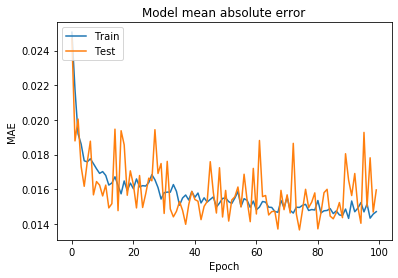

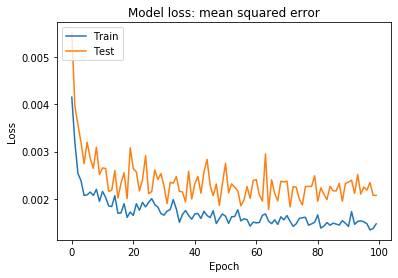

                      Municipio    Expected  Predicted      Error
0                   FÁTIMA (TO)    0.000000   0.000000   0.000000
1      SANTA CRUZ DO ARARI (PA)    0.000000   0.000000   0.000000
2             SERINGUEIRAS (RO)    6.869486   7.556911   0.687425
3                   PORTEL (PA)  107.897858  57.928692  49.969166
4    ALTA FLORESTA D'OESTE (RO)    5.045241  10.657132   5.611891
..                          ...         ...        ...        ...
755            SANTA LUZIA (MA)    1.311436   0.000000   1.311436
756               ALVORADA (TO)    0.000000   0.000000   0.000000
757       PONTES E LACERDA (MT)    2.124425   0.121519   2.002905
758       VITÓRIA DO XINGU (PA)   47.117195  18.131395  28.985800
759  SÃO FÉLIX DO ARAGUAIA (MT)   20.558084  21.950220   1.392136

[760 rows x 4 columns]
Muestra: 760 municipios
Error absoluto medio: 4.4711156
Deforestación predicha: 4704.749551288784 
Deforestación real: 6050.168898411095 
Error (%): 22.237715503705157
Datos obtenidos


/home/luisjvca/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:355: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/home/luisjvca/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:356: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)


Train: (41040, 3, 6) (41040, 14) (41040, 1)
Validation: (4560, 3, 6) (4560, 14) (4560, 1)
Creando el modelo...
	Capas intermedias 1
	Número de épocas: 5
	Batch size: 32
	Muestra para training: 4560 municipios
Model: "model_78"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_155 (InputLayer)          (None, 3, 6)         0                                            
__________________________________________________________________________________________________
masking_78 (Masking)            (None, 3, 6)         0           input_155[0][0]                  
__________________________________________________________________________________________________
lstm_78 (LSTM)                  (None, 5)            240         masking_78[0][0]                 
________________________________________________________________________________

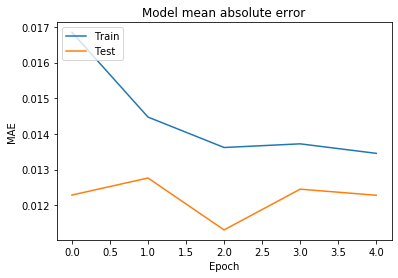

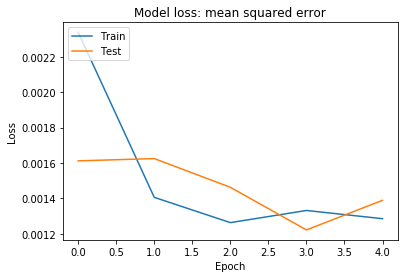

                       Municipio    Expected  Predicted      Error
0                    FÁTIMA (TO)    0.000000   0.000000   0.000000
1       SANTA CRUZ DO ARARI (PA)    0.000000   0.357870   0.357870
2              SERINGUEIRAS (RO)    6.869486   9.581335   2.711849
3                    PORTEL (PA)  107.897850  74.898216  32.999634
4     ALTA FLORESTA D'OESTE (RO)    5.045241   9.290536   4.245295
...                          ...         ...        ...        ...
4555       MIRANORTE (TO) fake_0    0.000000   0.000000   0.000000
4556        ÁGUA BOA (MT) fake_4    0.787914   0.000000   0.787914
4557        INDIAVAÍ (MT) fake_2    0.000000   0.000000   0.000000
4558     NOVA NAZARÉ (MT) fake_1    0.168691   0.000000   0.168691
4559   ALTO PARAGUAI (MT) fake_1    0.321120   0.000000   0.321120

[4560 rows x 4 columns]
Muestra: 4560 municipios
Error absoluto medio: 5.005399
Deforestación predicha: 32837.19754646905 
Deforestación real: 36270.22787196934 
Error (%): 9.465146835080784
Crea

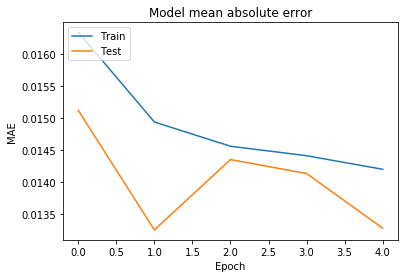

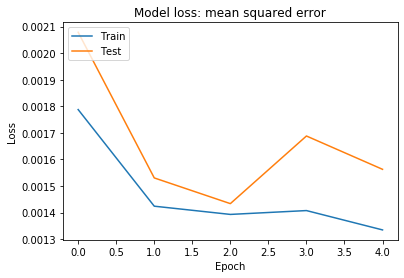

                       Municipio    Expected  Predicted      Error
0                    FÁTIMA (TO)    0.000000   0.000000   0.000000
1       SANTA CRUZ DO ARARI (PA)    0.000000   7.539574   7.539574
2              SERINGUEIRAS (RO)    6.869486   7.050929   0.181443
3                    PORTEL (PA)  107.897850  21.884972  86.012878
4     ALTA FLORESTA D'OESTE (RO)    5.045241   7.050929   2.005688
...                          ...         ...        ...        ...
4555       MIRANORTE (TO) fake_0    0.000000   0.000000   0.000000
4556        ÁGUA BOA (MT) fake_4    0.787914   2.498017   1.710103
4557        INDIAVAÍ (MT) fake_2    0.000000   0.000000   0.000000
4558     NOVA NAZARÉ (MT) fake_1    0.168691   0.129481   0.039209
4559   ALTO PARAGUAI (MT) fake_1    0.321120   0.000000   0.321120

[4560 rows x 4 columns]
Muestra: 4560 municipios
Error absoluto medio: 5.769824
Deforestación predicha: 33976.67297179997 
Deforestación real: 36270.22787196934 
Error (%): 6.3235194117484355
Cre

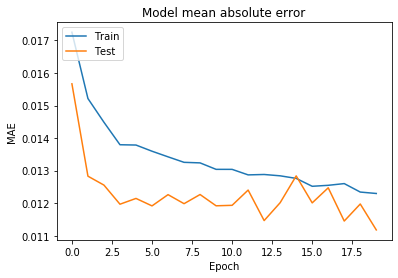

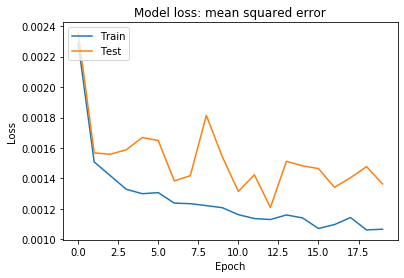

                       Municipio    Expected  Predicted      Error
0                    FÁTIMA (TO)    0.000000   0.000000   0.000000
1       SANTA CRUZ DO ARARI (PA)    0.000000   0.000000   0.000000
2              SERINGUEIRAS (RO)    6.869486   6.053330   0.816156
3                    PORTEL (PA)  107.897850  77.432159  30.465691
4     ALTA FLORESTA D'OESTE (RO)    5.045241   6.618762   1.573521
...                          ...         ...        ...        ...
4555       MIRANORTE (TO) fake_0    0.000000   0.000000   0.000000
4556        ÁGUA BOA (MT) fake_4    0.787914   0.000000   0.787914
4557        INDIAVAÍ (MT) fake_2    0.000000   0.000000   0.000000
4558     NOVA NAZARÉ (MT) fake_1    0.168691   0.000000   0.168691
4559   ALTO PARAGUAI (MT) fake_1    0.321120   0.000000   0.321120

[4560 rows x 4 columns]
Muestra: 4560 municipios
Error absoluto medio: 4.6091623
Deforestación predicha: 29504.957545863464 
Deforestación real: 36270.22787196934 
Error (%): 18.652406458505517
C

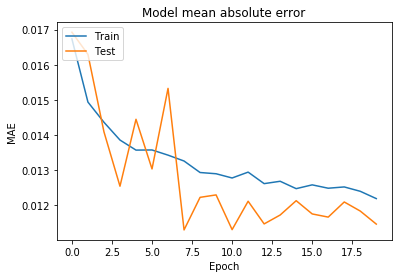

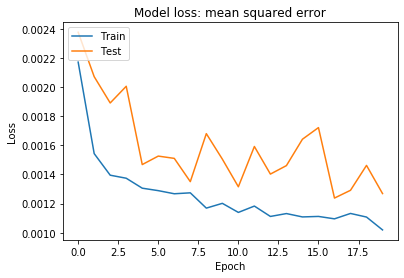

                       Municipio    Expected  Predicted      Error
0                    FÁTIMA (TO)    0.000000   0.000000   0.000000
1       SANTA CRUZ DO ARARI (PA)    0.000000   0.000000   0.000000
2              SERINGUEIRAS (RO)    6.869486   4.054558   2.814928
3                    PORTEL (PA)  107.897850  60.589691  47.308159
4     ALTA FLORESTA D'OESTE (RO)    5.045241   5.561918   0.516677
...                          ...         ...        ...        ...
4555       MIRANORTE (TO) fake_0    0.000000   0.000000   0.000000
4556        ÁGUA BOA (MT) fake_4    0.787914   0.000000   0.787914
4557        INDIAVAÍ (MT) fake_2    0.000000   0.000000   0.000000
4558     NOVA NAZARÉ (MT) fake_1    0.168691   0.000000   0.168691
4559   ALTO PARAGUAI (MT) fake_1    0.321120   0.000000   0.321120

[4560 rows x 4 columns]
Muestra: 4560 municipios
Error absoluto medio: 4.682955
Deforestación predicha: 28908.770671543665 
Deforestación real: 36270.22787196934 
Error (%): 20.296142683224826
Cr


Epoch 00032: val_loss did not improve from 0.00122
Epoch 33/50
 - 15s - loss: 0.0010 - mae: 0.0118 - val_loss: 0.0012 - val_mae: 0.0112

Epoch 00033: val_loss improved from 0.00122 to 0.00117, saving model to modelos2/model_1_50_32_5.h5
Epoch 34/50
 - 15s - loss: 0.0010 - mae: 0.0118 - val_loss: 0.0014 - val_mae: 0.0111

Epoch 00034: val_loss did not improve from 0.00117
Epoch 35/50
 - 15s - loss: 0.0010 - mae: 0.0117 - val_loss: 0.0014 - val_mae: 0.0114

Epoch 00035: val_loss did not improve from 0.00117
Epoch 36/50
 - 15s - loss: 0.0010 - mae: 0.0119 - val_loss: 0.0013 - val_mae: 0.0107

Epoch 00036: val_loss did not improve from 0.00117
Epoch 37/50
 - 15s - loss: 0.0010 - mae: 0.0117 - val_loss: 0.0014 - val_mae: 0.0111

Epoch 00037: val_loss did not improve from 0.00117
Epoch 38/50
 - 15s - loss: 0.0010 - mae: 0.0117 - val_loss: 0.0013 - val_mae: 0.0106

Epoch 00038: val_loss did not improve from 0.00117
Epoch 39/50
 - 15s - loss: 9.8489e-04 - mae: 0.0116 - val_loss: 0.0013 - val_

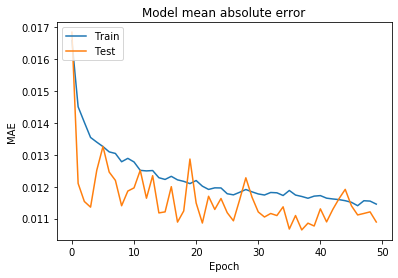

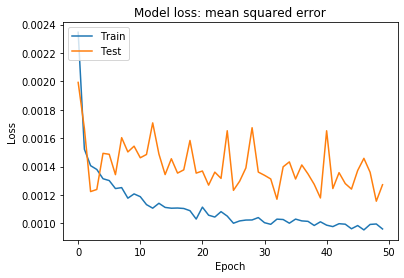

                       Municipio    Expected  Predicted      Error
0                    FÁTIMA (TO)    0.000000   0.000000   0.000000
1       SANTA CRUZ DO ARARI (PA)    0.000000   0.000000   0.000000
2              SERINGUEIRAS (RO)    6.869486  10.459084   3.589598
3                    PORTEL (PA)  107.897850  89.245537  18.652313
4     ALTA FLORESTA D'OESTE (RO)    5.045241   5.052235   0.006993
...                          ...         ...        ...        ...
4555       MIRANORTE (TO) fake_0    0.000000   0.000000   0.000000
4556        ÁGUA BOA (MT) fake_4    0.787914   0.000000   0.787914
4557        INDIAVAÍ (MT) fake_2    0.000000   0.000000   0.000000
4558     NOVA NAZARÉ (MT) fake_1    0.168691   0.000000   0.168691
4559   ALTO PARAGUAI (MT) fake_1    0.321120   0.000000   0.321120

[4560 rows x 4 columns]
Muestra: 4560 municipios
Error absoluto medio: 4.505739
Deforestación predicha: 28645.80123409722 
Deforestación real: 36270.22787196934 
Error (%): 21.021171040848337
Cre

 - 8s - loss: 0.0011 - mae: 0.0124 - val_loss: 0.0011 - val_mae: 0.0129

Epoch 00030: val_loss improved from 0.00123 to 0.00115, saving model to modelos2/model_1_50_64_5.h5
Epoch 31/50
 - 8s - loss: 0.0011 - mae: 0.0123 - val_loss: 0.0016 - val_mae: 0.0119

Epoch 00031: val_loss did not improve from 0.00115
Epoch 32/50
 - 8s - loss: 0.0011 - mae: 0.0123 - val_loss: 0.0013 - val_mae: 0.0126

Epoch 00032: val_loss did not improve from 0.00115
Epoch 33/50
 - 8s - loss: 0.0011 - mae: 0.0123 - val_loss: 0.0014 - val_mae: 0.0118

Epoch 00033: val_loss did not improve from 0.00115
Epoch 34/50
 - 8s - loss: 0.0010 - mae: 0.0122 - val_loss: 0.0015 - val_mae: 0.0121

Epoch 00034: val_loss did not improve from 0.00115
Epoch 35/50
 - 8s - loss: 0.0010 - mae: 0.0121 - val_loss: 0.0014 - val_mae: 0.0118

Epoch 00035: val_loss did not improve from 0.00115
Epoch 36/50
 - 8s - loss: 0.0011 - mae: 0.0122 - val_loss: 0.0014 - val_mae: 0.0125

Epoch 00036: val_loss did not improve from 0.00115
Epoch 37/50

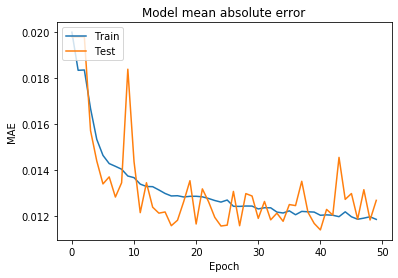

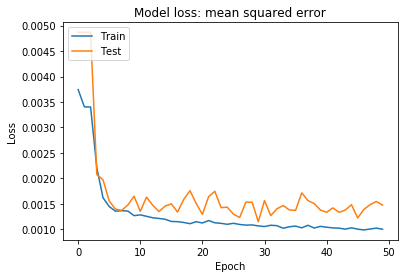

                       Municipio    Expected  Predicted      Error
0                    FÁTIMA (TO)    0.000000   0.000000   0.000000
1       SANTA CRUZ DO ARARI (PA)    0.000000   0.000000   0.000000
2              SERINGUEIRAS (RO)    6.869486  13.260410   6.390924
3                    PORTEL (PA)  107.897850  73.843208  34.054642
4     ALTA FLORESTA D'OESTE (RO)    5.045241  13.136710   8.091469
...                          ...         ...        ...        ...
4555       MIRANORTE (TO) fake_0    0.000000   0.000000   0.000000
4556        ÁGUA BOA (MT) fake_4    0.787914   3.338382   2.550468
4557        INDIAVAÍ (MT) fake_2    0.000000   3.721917   3.721917
4558     NOVA NAZARÉ (MT) fake_1    0.168691   3.066643   2.897953
4559   ALTO PARAGUAI (MT) fake_1    0.321120   3.644371   3.323252

[4560 rows x 4 columns]
Muestra: 4560 municipios
Error absoluto medio: 5.1691365
Deforestación predicha: 36721.35151799861 
Deforestación real: 36270.22787196934 
Error (%): 1.2437849787481272
Cr


Epoch 00031: val_loss did not improve from 0.00127
Epoch 32/100
 - 15s - loss: 9.9929e-04 - mae: 0.0117 - val_loss: 0.0013 - val_mae: 0.0109

Epoch 00032: val_loss did not improve from 0.00127
Epoch 33/100
 - 15s - loss: 9.8810e-04 - mae: 0.0116 - val_loss: 0.0016 - val_mae: 0.0121

Epoch 00033: val_loss did not improve from 0.00127
Epoch 34/100
 - 15s - loss: 9.6355e-04 - mae: 0.0116 - val_loss: 0.0015 - val_mae: 0.0117

Epoch 00034: val_loss did not improve from 0.00127
Epoch 35/100
 - 15s - loss: 0.0010 - mae: 0.0118 - val_loss: 0.0012 - val_mae: 0.0110

Epoch 00035: val_loss improved from 0.00127 to 0.00120, saving model to modelos2/model_1_100_32_5.h5
Epoch 36/100
 - 15s - loss: 9.7788e-04 - mae: 0.0115 - val_loss: 0.0012 - val_mae: 0.0112

Epoch 00036: val_loss improved from 0.00120 to 0.00117, saving model to modelos2/model_1_100_32_5.h5
Epoch 37/100
 - 15s - loss: 9.8153e-04 - mae: 0.0116 - val_loss: 0.0015 - val_mae: 0.0121

Epoch 00037: val_loss did not improve from 0.00117


 - 15s - loss: 8.2103e-04 - mae: 0.0109 - val_loss: 0.0014 - val_mae: 0.0113

Epoch 00088: val_loss did not improve from 0.00109
Epoch 89/100
 - 15s - loss: 9.1154e-04 - mae: 0.0111 - val_loss: 0.0014 - val_mae: 0.0121

Epoch 00089: val_loss did not improve from 0.00109
Epoch 90/100
 - 15s - loss: 8.8988e-04 - mae: 0.0112 - val_loss: 0.0013 - val_mae: 0.0113

Epoch 00090: val_loss did not improve from 0.00109
Epoch 91/100
 - 15s - loss: 8.7829e-04 - mae: 0.0110 - val_loss: 0.0016 - val_mae: 0.0142

Epoch 00091: val_loss did not improve from 0.00109
Epoch 92/100
 - 15s - loss: 8.8294e-04 - mae: 0.0111 - val_loss: 0.0013 - val_mae: 0.0120

Epoch 00092: val_loss did not improve from 0.00109
Epoch 93/100
 - 16s - loss: 8.5560e-04 - mae: 0.0109 - val_loss: 0.0014 - val_mae: 0.0117

Epoch 00093: val_loss did not improve from 0.00109
Epoch 94/100
 - 15s - loss: 9.0190e-04 - mae: 0.0111 - val_loss: 0.0017 - val_mae: 0.0122

Epoch 00094: val_loss did not improve from 0.00109
Epoch 95/100
 - 15s

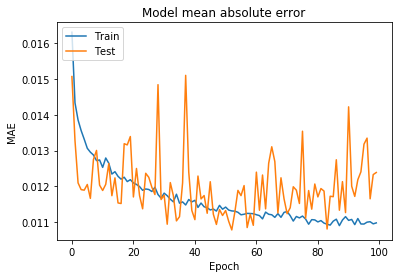

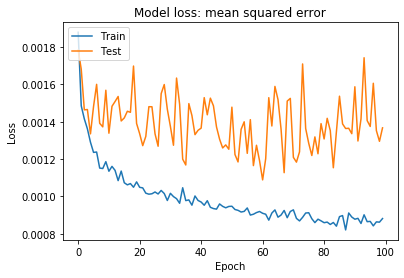

                       Municipio    Expected  Predicted      Error
0                    FÁTIMA (TO)    0.000000   0.000000   0.000000
1       SANTA CRUZ DO ARARI (PA)    0.000000   0.000000   0.000000
2              SERINGUEIRAS (RO)    6.869486  14.738632   7.869146
3                    PORTEL (PA)  107.897850  64.640930  43.256920
4     ALTA FLORESTA D'OESTE (RO)    5.045241  15.964271  10.919029
...                          ...         ...        ...        ...
4555       MIRANORTE (TO) fake_0    0.000000   0.000000   0.000000
4556        ÁGUA BOA (MT) fake_4    0.787914   0.000000   0.787914
4557        INDIAVAÍ (MT) fake_2    0.000000   0.000000   0.000000
4558     NOVA NAZARÉ (MT) fake_1    0.168691   0.000000   0.168691
4559   ALTO PARAGUAI (MT) fake_1    0.321120   0.000000   0.321120

[4560 rows x 4 columns]
Muestra: 4560 municipios
Error absoluto medio: 4.983291
Deforestación predicha: 38078.09257984534 
Deforestación real: 36270.22787196934 
Error (%): 4.984431623251989
Crea

 - 8s - loss: 9.7098e-04 - mae: 0.0117 - val_loss: 0.0013 - val_mae: 0.0112

Epoch 00032: val_loss did not improve from 0.00114
Epoch 33/100
 - 8s - loss: 9.6280e-04 - mae: 0.0116 - val_loss: 0.0014 - val_mae: 0.0112

Epoch 00033: val_loss did not improve from 0.00114
Epoch 34/100
 - 8s - loss: 9.7759e-04 - mae: 0.0117 - val_loss: 0.0015 - val_mae: 0.0112

Epoch 00034: val_loss did not improve from 0.00114
Epoch 35/100
 - 8s - loss: 9.6954e-04 - mae: 0.0116 - val_loss: 0.0014 - val_mae: 0.0118

Epoch 00035: val_loss did not improve from 0.00114
Epoch 36/100
 - 8s - loss: 9.8141e-04 - mae: 0.0116 - val_loss: 0.0014 - val_mae: 0.0115

Epoch 00036: val_loss did not improve from 0.00114
Epoch 37/100
 - 8s - loss: 9.6386e-04 - mae: 0.0116 - val_loss: 0.0013 - val_mae: 0.0126

Epoch 00037: val_loss did not improve from 0.00114
Epoch 38/100
 - 8s - loss: 9.6621e-04 - mae: 0.0117 - val_loss: 0.0013 - val_mae: 0.0109

Epoch 00038: val_loss did not improve from 0.00114
Epoch 39/100
 - 8s - loss:


Epoch 00090: val_loss did not improve from 0.00114
Epoch 91/100
 - 8s - loss: 8.7346e-04 - mae: 0.0110 - val_loss: 0.0014 - val_mae: 0.0122

Epoch 00091: val_loss did not improve from 0.00114
Epoch 92/100
 - 8s - loss: 9.0896e-04 - mae: 0.0111 - val_loss: 0.0014 - val_mae: 0.0120

Epoch 00092: val_loss did not improve from 0.00114
Epoch 93/100
 - 8s - loss: 8.9180e-04 - mae: 0.0111 - val_loss: 0.0014 - val_mae: 0.0121

Epoch 00093: val_loss did not improve from 0.00114
Epoch 94/100
 - 8s - loss: 8.7327e-04 - mae: 0.0111 - val_loss: 0.0015 - val_mae: 0.0118

Epoch 00094: val_loss did not improve from 0.00114
Epoch 95/100
 - 8s - loss: 8.5459e-04 - mae: 0.0110 - val_loss: 0.0015 - val_mae: 0.0127

Epoch 00095: val_loss did not improve from 0.00114
Epoch 96/100
 - 8s - loss: 8.7746e-04 - mae: 0.0109 - val_loss: 0.0013 - val_mae: 0.0121

Epoch 00096: val_loss did not improve from 0.00114
Epoch 97/100
 - 8s - loss: 8.8075e-04 - mae: 0.0111 - val_loss: 0.0014 - val_mae: 0.0125

Epoch 00097:

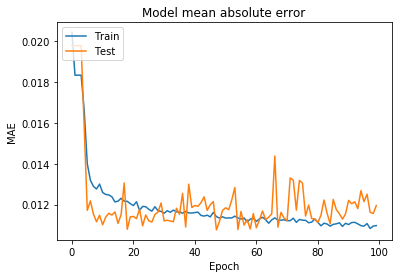

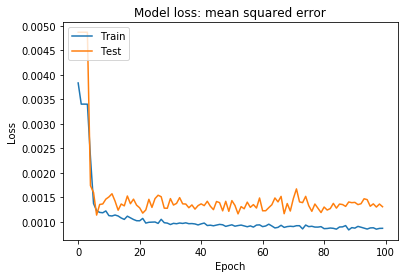

                       Municipio    Expected  Predicted      Error
0                    FÁTIMA (TO)    0.000000   0.000000   0.000000
1       SANTA CRUZ DO ARARI (PA)    0.000000   0.000000   0.000000
2              SERINGUEIRAS (RO)    6.869486  11.690617   4.821131
3                    PORTEL (PA)  107.897850  64.260574  43.637276
4     ALTA FLORESTA D'OESTE (RO)    5.045241   9.666142   4.620901
...                          ...         ...        ...        ...
4555       MIRANORTE (TO) fake_0    0.000000   0.000000   0.000000
4556        ÁGUA BOA (MT) fake_4    0.787914   0.545702   0.242212
4557        INDIAVAÍ (MT) fake_2    0.000000   1.320252   1.320252
4558     NOVA NAZARÉ (MT) fake_1    0.168691   0.000000   0.168691
4559   ALTO PARAGUAI (MT) fake_1    0.321120   1.476500   1.155380

[4560 rows x 4 columns]
Muestra: 4560 municipios
Error absoluto medio: 4.897069
Deforestación predicha: 35388.2028391319 
Deforestación real: 36270.22787196934 
Error (%): 2.431815526362029
Crean

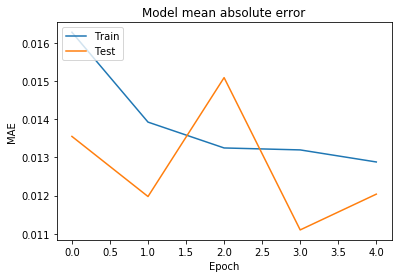

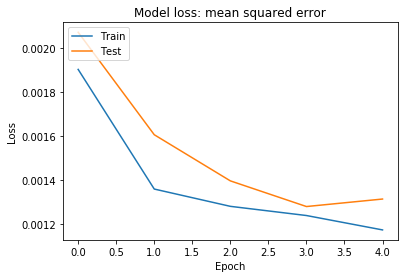

                       Municipio    Expected  Predicted      Error
0                    FÁTIMA (TO)    0.000000   0.000000   0.000000
1       SANTA CRUZ DO ARARI (PA)    0.000000   0.000000   0.000000
2              SERINGUEIRAS (RO)    6.869486   7.299735   0.430249
3                    PORTEL (PA)  107.897850  59.119694  48.778156
4     ALTA FLORESTA D'OESTE (RO)    5.045241   6.935524   1.890283
...                          ...         ...        ...        ...
4555       MIRANORTE (TO) fake_0    0.000000   0.000000   0.000000
4556        ÁGUA BOA (MT) fake_4    0.787914   0.000000   0.787914
4557        INDIAVAÍ (MT) fake_2    0.000000   0.000000   0.000000
4558     NOVA NAZARÉ (MT) fake_1    0.168691   0.000000   0.168691
4559   ALTO PARAGUAI (MT) fake_1    0.321120   0.000000   0.321120

[4560 rows x 4 columns]
Muestra: 4560 municipios
Error absoluto medio: 4.462499
Deforestación predicha: 24785.231539786037 
Deforestación real: 36270.22787196934 
Error (%): 31.66507906353474
Cre

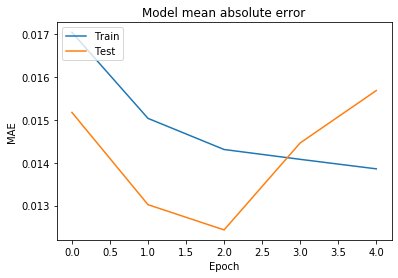

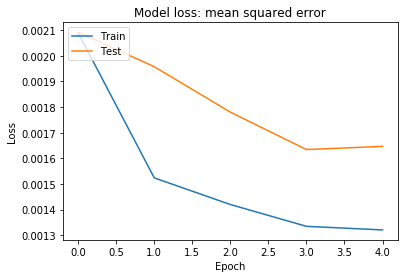

                       Municipio    Expected  Predicted      Error
0                    FÁTIMA (TO)    0.000000   0.000000   0.000000
1       SANTA CRUZ DO ARARI (PA)    0.000000   3.392464   3.392464
2              SERINGUEIRAS (RO)    6.869486   6.600883   0.268603
3                    PORTEL (PA)  107.897850  24.300480  83.597366
4     ALTA FLORESTA D'OESTE (RO)    5.045241   7.856448   2.811206
...                          ...         ...        ...        ...
4555       MIRANORTE (TO) fake_0    0.000000   0.000000   0.000000
4556        ÁGUA BOA (MT) fake_4    0.787914   2.708985   1.921071
4557        INDIAVAÍ (MT) fake_2    0.000000   4.131697   4.131697
4558     NOVA NAZARÉ (MT) fake_1    0.168691   1.280138   1.111448
4559   ALTO PARAGUAI (MT) fake_1    0.321120   3.948062   3.626942

[4560 rows x 4 columns]
Muestra: 4560 municipios
Error absoluto medio: 5.8133225
Deforestación predicha: 33542.20334956376 
Deforestación real: 36270.22787196934 
Error (%): 7.5213878777802705
Cr

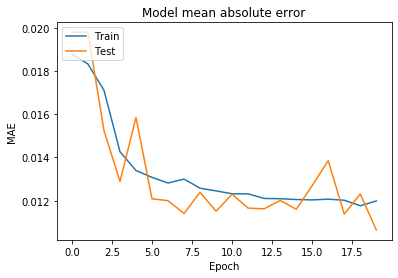

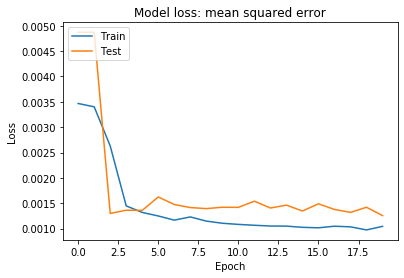

                       Municipio    Expected  Predicted      Error
0                    FÁTIMA (TO)    0.000000   0.000000   0.000000
1       SANTA CRUZ DO ARARI (PA)    0.000000   0.000000   0.000000
2              SERINGUEIRAS (RO)    6.869486   6.136358   0.733128
3                    PORTEL (PA)  107.897850  32.612961  75.284889
4     ALTA FLORESTA D'OESTE (RO)    5.045241   6.511235   1.465994
...                          ...         ...        ...        ...
4555       MIRANORTE (TO) fake_0    0.000000   0.000000   0.000000
4556        ÁGUA BOA (MT) fake_4    0.787914   0.000000   0.787914
4557        INDIAVAÍ (MT) fake_2    0.000000   0.000000   0.000000
4558     NOVA NAZARÉ (MT) fake_1    0.168691   0.000000   0.168691
4559   ALTO PARAGUAI (MT) fake_1    0.321120   0.000000   0.321120

[4560 rows x 4 columns]
Muestra: 4560 municipios
Error absoluto medio: 4.279617
Deforestación predicha: 24420.12119465694 
Deforestación real: 36270.22787196934 
Error (%): 32.67171830059139
Crea

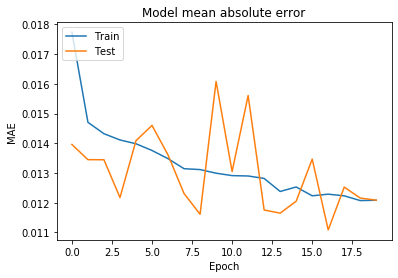

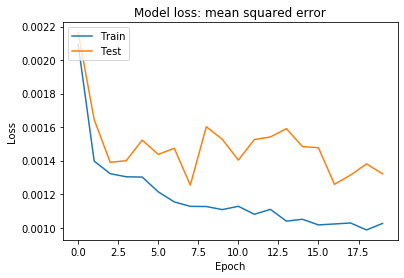

                       Municipio    Expected  Predicted      Error
0                    FÁTIMA (TO)    0.000000   0.000000   0.000000
1       SANTA CRUZ DO ARARI (PA)    0.000000   2.120948   2.120948
2              SERINGUEIRAS (RO)    6.869486   6.678139   0.191347
3                    PORTEL (PA)  107.897850  64.935852  42.961998
4     ALTA FLORESTA D'OESTE (RO)    5.045241   5.898888   0.853647
...                          ...         ...        ...        ...
4555       MIRANORTE (TO) fake_0    0.000000   0.000000   0.000000
4556        ÁGUA BOA (MT) fake_4    0.787914   3.107669   2.319755
4557        INDIAVAÍ (MT) fake_2    0.000000   3.181702   3.181702
4558     NOVA NAZARÉ (MT) fake_1    0.168691   2.909811   2.741121
4559   ALTO PARAGUAI (MT) fake_1    0.321120   3.103956   2.782837

[4560 rows x 4 columns]
Muestra: 4560 municipios
Error absoluto medio: 4.9470797
Deforestación predicha: 30624.33589301491 
Deforestación real: 36270.22787196934 
Error (%): 15.566188331884554
Cr

 - 18s - loss: 9.2253e-04 - mae: 0.0114 - val_loss: 0.0011 - val_mae: 0.0109

Epoch 00030: val_loss did not improve from 0.00104
Epoch 31/50
 - 19s - loss: 8.8615e-04 - mae: 0.0112 - val_loss: 0.0014 - val_mae: 0.0121

Epoch 00031: val_loss did not improve from 0.00104
Epoch 32/50
 - 18s - loss: 8.9402e-04 - mae: 0.0113 - val_loss: 0.0013 - val_mae: 0.0113

Epoch 00032: val_loss did not improve from 0.00104
Epoch 33/50
 - 18s - loss: 9.2016e-04 - mae: 0.0113 - val_loss: 0.0014 - val_mae: 0.0121

Epoch 00033: val_loss did not improve from 0.00104
Epoch 34/50
 - 18s - loss: 8.7024e-04 - mae: 0.0111 - val_loss: 0.0014 - val_mae: 0.0122

Epoch 00034: val_loss did not improve from 0.00104
Epoch 35/50
 - 17s - loss: 8.7705e-04 - mae: 0.0111 - val_loss: 0.0012 - val_mae: 0.0113

Epoch 00035: val_loss did not improve from 0.00104
Epoch 36/50
 - 16s - loss: 9.2327e-04 - mae: 0.0112 - val_loss: 0.0013 - val_mae: 0.0112

Epoch 00036: val_loss did not improve from 0.00104
Epoch 37/50
 - 17s - loss

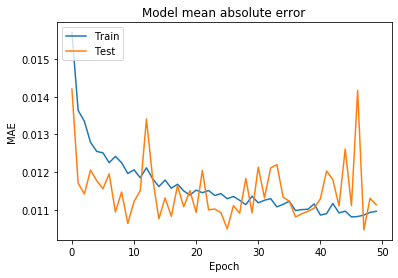

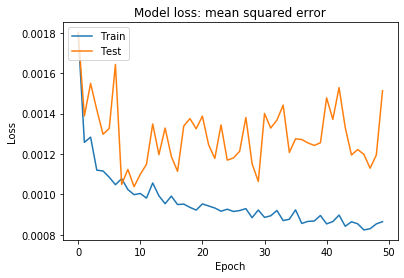

                       Municipio    Expected  Predicted      Error
0                    FÁTIMA (TO)    0.000000   0.000000   0.000000
1       SANTA CRUZ DO ARARI (PA)    0.000000   0.000000   0.000000
2              SERINGUEIRAS (RO)    6.869486   7.651689   0.782203
3                    PORTEL (PA)  107.897850  78.062767  29.835083
4     ALTA FLORESTA D'OESTE (RO)    5.045241   9.331663   4.286422
...                          ...         ...        ...        ...
4555       MIRANORTE (TO) fake_0    0.000000   0.000000   0.000000
4556        ÁGUA BOA (MT) fake_4    0.787914   0.000000   0.787914
4557        INDIAVAÍ (MT) fake_2    0.000000   0.000000   0.000000
4558     NOVA NAZARÉ (MT) fake_1    0.168691   0.000000   0.168691
4559   ALTO PARAGUAI (MT) fake_1    0.321120   0.000000   0.321120

[4560 rows x 4 columns]
Muestra: 4560 municipios
Error absoluto medio: 4.275529
Deforestación predicha: 28089.519946027547 
Deforestación real: 36270.22787196934 
Error (%): 22.554884283658104
Cr

In [ ]:
results = []
n_replics = [0,5,20,50]
for n in n_replics:
    if n == 0:
        df_complete = df
    else:
        fake_df = generate_fake_data(df, n)
        df_complete = df.append(fake_df)
    #df_complete = df_complete.sort_values(by=['Municipio']) # to be ommited for the test: 760 primeros municipios son los reales
    df_complete.loc[:,'Latitud':] = df_complete.loc[:,'Latitud':].astype('float')
    df_complete = df_complete.infer_objects()
    print("Datos obtenidos")
    
    #plot map
    name = 'mapa_fake' + str(n) + '.html'
    plot_map(df_complete, "mapas/" + name)

    #shuffle data
    df_complete[760:] = shuffle_df(df_complete[760:])
    
    # structure data
    fixed_vars = df_complete.loc[:,['Municipio', 'Estado', 'Latitud', 'Longitud', 'Area total', 'Hidrografia', 'No bosque']]
    temporal_vars = df_complete.loc[:,'Deforestacion 2000':]
    window_size=4
    temporal_train, temporal_test = series_to_supervised(temporal_vars, 0, window_size, n_vars_temp)
    temporal_train, temporal_valid = series_to_supervised(temporal_train, 0, window_size, n_vars_temp)
    #print(temporal_vars.head(), "\n", temporal_train.head(), "\n", temporal_valid.head(), "\n", temporal_test.head())
    
    # preprocess data for training and validation
    X1_train, X2_train, y_train, scaler, scaler2, scaler3 = preprocess_train(temporal_train, fixed_vars, n_vars_temp, window_size)
    print("Train:", X1_train.shape, X2_train.shape, y_train.shape)
    X1_valid, X2_valid, y_valid = preprocess_test(temporal_valid, X2_train, n_vars_temp, scaler, scaler2, scaler3)
    print("Validation:", X1_valid.shape, X2_valid.shape, y_valid.shape)
                
    # create model
    hidden_layers=[1,2,3]
    epochs=[5, 20, 50, 100]
    batch_sizes=[32, 64]
    for h in hidden_layers:
        for e in epochs:
            for bs in batch_sizes:
                print("Creando el modelo...")
                print('\tCapas intermedias', h)
                print("\tNúmero de épocas:", e)
                print('\tBatch size:', bs)
                print('\tMuestra para training:', len(df_complete), 'municipios')
                model_name = "model_" + str(h) + "_" + str(e) + "_" + str(bs) + "_" + str(n) + ".h5"
                model = create_model(window_size, n_vars_temp, h)
                model.compile(loss='mean_squared_error', optimizer='adam', metrics = ['mae'])
                # fit model
                checkpoint_cb = ModelCheckpoint("modelos2/" + model_name, save_best_only=True, verbose=1)
                history = model.fit([X1_train, X2_train], y_train, epochs=e, batch_size=bs, verbose=2, validation_data=([X1_valid, X2_valid], y_valid), callbacks=[checkpoint_cb])

                # Plot training & validation accuracy values
                plt.plot(history.history['mae'])
                plt.plot(history.history['val_mae'])
                plt.title('Model mean absolute error')
                plt.ylabel('MAE')
                plt.xlabel('Epoch')
                plt.legend(['Train', 'Test'], loc='upper left')
                plt.show()

                # Plot training & validation loss values
                plt.plot(history.history['loss'])
                plt.plot(history.history['val_loss'])
                plt.title('Model loss: mean squared error')
                plt.ylabel('Loss')
                plt.xlabel('Epoch')
                plt.legend(['Train', 'Test'], loc='upper left')
                plt.show()

                # evaluate model on validation data
                model = load_model("modelos2/" + model_name)
                y_pred = model.predict([X1_valid, X2_valid])
                val, total = evaluate_test(fixed_vars[['Municipio']], y_valid, y_pred)

                d = {}
                d['Municipios'] = len(df_complete)
                d['Epocas'] = e
                d['Batch size'] = bs
                d['Capas intermedias'] = h
                d['Error absoluto medio'] = val['Error'].mean()
                d['Error total deforestacion'] = abs(total['Predicted']-total['Expected'])/total['Expected']*100
                results.append(d)

df_results = pd.DataFrame(results)
df_results.to_excel('resultados/precision_configuraciones_modelo2.xlsx') # results of the different configurations

In [ ]:
df_results = pd.DataFrame(results)
df_results.describe()

In [ ]:
df_results

In [ ]:
# TODO: check  que la y se corresponde con el municipio

In [ ]:
# Comparacion de los resultados de distintos modelos
#df_results = pd.read_excel('resultados/precision_configuraciones_modelo_10rep.xlsx')

In [ ]:
x=[]
mean_y=[]
min_y=[]
max_y=[]
for n in sorted(set(df_results['Municipios'].values)):
    mun = df_results[df_results['Municipios']==n]
    desc = mun['Error total deforestacion'].describe()
    x.append(n)
    mean_y.append(desc['mean'])
    min_y.append(desc['min'])
    max_y.append(desc['max'])
    

In [ ]:
import matplotlib.pyplot as plt
plt.plot(x,mean_y, label='Error medio')
plt.plot(x,min_y, label='Error mínimmo')
plt.plot(x,max_y, label='Error máximo')
plt.ylabel('Error (%)')
plt.xlabel('Número de municipios')
plt.legend()
plt.show()

In [ ]:
# evaluate model on test set
h=2
e=50
bs=32
n=20

df.loc[:,'Latitud':] = df.loc[:,'Latitud':].astype('float')

#shuffle data
df = shuffle_df(df)

# structure data
fixed_vars = df_complete.loc[:,['Municipio', 'Estado', 'Latitud', 'Longitud', 'Area total', 'Hidrografia', 'No bosque']]
temporal_vars = df_complete.loc[:,'Deforestacion 2000':]
window_size=4
temporal_train, temporal_test = series_to_supervised(temporal_vars, 0, window_size, n_vars_temp)

# preprocess data for testing
X1_test, X2_test, y_test = preprocess_test(temporal_test, X2_train, n_vars_temp, scaler, scaler2, scaler3)
print("Test:", X1_test.shape, X2_test.shape, y_test.shape)
municipios_reales = fixed_vars.iloc[0:760,0]
print("Datos preprocesados")

model_name = "model_" + str(h) + "_" + str(e) + "_" + str(bs) + "_" + str(n) + ".h5"
model = load_model("modelos2/" + model_name)
y_pred = model.predict([X1_test, X2_test])
test = evaluate_test(municipios_reales, y_test, y_pred)

In [ ]:
# TODO:
# crear modelo en producción y predecir los n años próximos
# balancear fake por importancia de municipios
# carpetas en drive: datos, code, resultados, memoria

In [1]:
df_results

NameError: name 'df_results' is not defined